In [ ]:
pip install mat73

In [ ]:
from scipy import stats
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from mat73 import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras

tfk = tf.keras
tfkl = tf.keras.layers

#PREPROCESSING PART


In [ ]:
import pickle

with open('Subset2205.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
df = pd.DataFrame(data)
df = df.drop(columns='FMP')
df.head()

,patnum,id_prestazione,sett_gestazione,label,FHR120bpm,TOCO
0,2506.0,6933.0,35.0,0.0,"[153.0, 152.0, 153.5, 156.5, 154.25, 157.25, 1...","[6.0, 6.0, 7.0, 4.0, 5.0, 4.0, 1.0, 1.0, 2.0, ..."
1,2268.0,5929.0,37.0,1.0,"[141.75, 142.0, 141.75, 142.25, 142.75, 143.25...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
2,3709.0,10614.0,37.0,0.0,"[155.0, 154.25, 161.0, 161.0, 161.0, 161.0, 16...","[25.0, 27.0, 29.0, 27.0, 27.0, 27.0, 25.0, 28...."
3,4066.0,11996.0,37.0,0.0,"[136.75, 136.75, 135.0, 135.0, 132.0, 131.25, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1679.0,4386.0,37.0,0.0,"[140.75, 138.5, 139.5, 138.25, 141.5, 143.75, ...","[10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 13.0, 21.0, 24..."


In [ ]:
to_convert = ['patnum', 'sett_gestazione', 'label','id_prestazione']
df[to_convert] = df[to_convert].astype(float)

In [ ]:
X = df[['FHR120bpm','TOCO', 'sett_gestazione','id_prestazione']].values
y = df['label'].values
groups = df['patnum'].values

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
# Definisci la suddivisione usando GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Fai lo split in train e test
for train_idx, test_idx in gss.split(X, y, groups=groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    groups_train, groups_test = groups[train_idx], groups[test_idx]



In [ ]:
# Ora puoi suddividere X_train, X_test, y_train, y_test in train/validation a tuo piacimento
# Ad esempio, dividiamo ulteriormente il train set in train/validation
gss_train = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, val_idx in gss_train.split(X_train, y_train, groups=groups_train):
    X_train, X_val = X_train[train_idx], X_train[val_idx]
    y_train, y_val = y_train[train_idx], y_train[val_idx]
    groups_train, groups_val = groups_train[train_idx], groups_train[val_idx]

In [ ]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((369, 4), (44, 4), (145, 4), (369,), (44,), (145,))

In [ ]:
def find_n_windows(l_signal,w_window=2400):
    n_windows=np.ceil(l_signal/w_window)
    overlap=np.ceil(((n_windows*w_window)-l_signal)/(n_windows-1))
    if overlap*(n_windows-1)>1200:
        n_windows=n_windows-1
        overlap=0
    return n_windows,overlap

In [ ]:
def windowing(df, w_window, Test = False):
    # prende in ingresso un df con colonne: patnum, label, StimaEtaGest, FHR120bp, TOCO e la larghezza della finestra

    #df vuoto come df in input -> lo devo popolare
    df_post_win= pd.DataFrame(columns=df.columns)

    for i in range(len(df)):
        current_patnum = df.loc[i, 'patnum']
        current_label = df.loc[i, 'label']
        current_etaGest = df.loc[i, 'sett_gestazione']
        l_signal = len(df.loc[i, 'FHR120bpm'])
        id_prestazione = df.loc[i, 'id_prestazione']

        n_windows,overlap = find_n_windows(l_signal, w_window)


        if Test == True:
            if n_windows%2==0:
                n_windows = n_windows + 1
                overlap=np.ceil(((n_windows*w_window)-l_signal)/(n_windows-1))




        for n in range(1, int(n_windows)+1):
            start_index = int((n - 1) * (w_window - overlap))
            end_index = int(start_index+w_window)

            new_FHR = df.at[i, 'FHR120bpm'][start_index:end_index]
            new_TOCO = df.at[i, 'TOCO'][start_index:end_index]

            new_row = pd.DataFrame({'patnum': [current_patnum],
                                    'TOCO': [new_TOCO],
                                    'sett_gestazione': [current_etaGest],
                                    'label': [current_label],
                                    'FHR120bpm': [new_FHR],
                                    'id_prestazione': [id_prestazione]})
            df_post_win = pd.concat([df_post_win, new_row], ignore_index=True)



    return df_post_win


In [ ]:
X_train_df = pd.DataFrame(X_train, columns = ['FHR120bpm','TOCO','sett_gestazione','id_prestazione'])
y_train_series = pd.Series(y_train, name='label')
train_patnum_series = pd.Series(groups_train, name='patnum')
train = pd.concat([X_train_df,train_patnum_series, y_train_series], axis=1).reset_index(drop=True)


In [ ]:
train_win=windowing(train, 2400)
train_win.head(10)

<ipython-input-12-fb01acf84ee0>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_post_win = pd.concat([df_post_win, new_row], ignore_index=True)


,FHR120bpm,TOCO,sett_gestazione,id_prestazione,patnum,label
0,"[141.75, 142.0, 141.75, 142.25, 142.75, 143.25...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",37.0,5929.0,2268.0,1.0
1,"[155.0, 154.25, 161.0, 161.0, 161.0, 161.0, 16...","[25.0, 27.0, 29.0, 27.0, 27.0, 27.0, 25.0, 28....",37.0,10614.0,3709.0,0.0
2,"[176.75, 176.75, 176.25, 175.0, 173.5, 173.25,...","[18.0, 17.0, 17.0, 18.0, 19.0, 18.0, 17.0, 18....",37.0,10614.0,3709.0,0.0
3,"[155.75, 157.25, 156.0, 155.5, 156.5, 156.5, 1...","[13.0, 10.0, 9.0, 11.0, 10.0, 10.0, 10.0, 9.0,...",37.0,10614.0,3709.0,0.0
4,"[126.0, 126.25, 126.5, 128.0, 128.0, 128.0, 12...","[18.0, 17.0, 18.0, 18.0, 17.0, 18.0, 18.0, 18....",36.0,27896.0,8665.0,0.0
5,"[124.25, 124.5, 124.75, 124.5, 124.75, 125.0, ...","[29.0, 30.0, 29.0, 29.0, 29.0, 30.0, 30.0, 29....",36.0,27896.0,8665.0,0.0
6,"[128.25, 128.25, 128.25, 126.75, 120.5, 129.75...","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....",38.0,20717.0,6643.0,1.0
7,"[146.0, 147.25, 147.0, 144.75, 143.75, 141.75,...","[22.0, 23.0, 23.0, 23.0, 22.0, 22.0, 22.0, 22....",38.0,20717.0,6643.0,1.0
8,"[134.25, 131.25, 130.0, 128.75, 127.25, 126.25...","[24.0, 25.0, 25.0, 25.0, 24.0, 25.0, 25.0, 24....",38.0,20717.0,6643.0,1.0
9,"[143.5, 144.0, 143.25, 141.25, 141.75, 144.75,...","[2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",35.0,139.0,83.0,0.0


In [ ]:
train_win['FHR_len']=train_win['FHR120bpm'].apply(len)
train_win['TOCO_len']=train_win['TOCO'].apply(len)
train_win['FHR_len'].min(), train_win['FHR_len'].max(), train_win['TOCO_len'].min(), train_win['TOCO_len'].max()

(2400, 2400, 2400, 2400)

In [ ]:
X_train = train_win[['FHR120bpm','TOCO', 'sett_gestazione']].values # se vuoi più colonne usa le doppie quadre
y_train = train_win['label'].values
X_train.shape,y_train.shape, sum(y_train)

((827, 3), (827,), 427.0)

In [ ]:
X_val_df = pd.DataFrame(X_val, columns = ['FHR120bpm','TOCO','sett_gestazione','id_prestazione'])
y_val_series = pd.Series(y_val, name='label')
val_patnum_series = pd.Series(groups_val, name='patnum')
val = pd.concat([X_val_df,val_patnum_series, y_val_series], axis=1).reset_index(drop=True)
val_win=windowing(val, 2400)
val_win

<ipython-input-12-fb01acf84ee0>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_post_win = pd.concat([df_post_win, new_row], ignore_index=True)


,FHR120bpm,TOCO,sett_gestazione,id_prestazione,patnum,label
0,"[153.0, 152.0, 153.5, 156.5, 154.25, 157.25, 1...","[6.0, 6.0, 7.0, 4.0, 5.0, 4.0, 1.0, 1.0, 2.0, ...",35.0,6933.0,2506.0,0.0
1,"[150.0, 150.0, 151.0, 151.25, 152.0, 151.0, 15...","[1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,6933.0,2506.0,0.0
2,"[136.75, 136.75, 135.0, 135.0, 132.0, 131.25, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37.0,11996.0,4066.0,0.0
3,"[127.0, 127.25, 128.0, 129.5, 129.75, 130.25, ...","[17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 17.0, 17....",37.0,11996.0,4066.0,0.0
4,"[139.0, 139.0, 144.0, 144.75, 145.0, 145.25, 1...","[20.0, 19.0, 20.0, 19.0, 20.0, 19.0, 19.0, 19....",35.0,22250.0,6914.0,1.0
...,...,...,...,...,...,...
313,"[135.0, 134.25, 133.0, 132.75, 132.0, 133.0, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,946.0,400.0,0.0
314,"[146.5, 146.5, 146.25, 146.25, 146.20833333333...","[98.0, 100.0, 101.0, 99.0, 95.0, 95.0, 82.0, 6...",38.0,4325.0,1669.0,0.0
315,"[137.0, 136.25, 143.25, 136.75, 142.75, 141.5,...","[12.0, 14.0, 14.0, 14.0, 13.0, 12.0, 13.0, 14....",38.0,4325.0,1669.0,0.0
316,"[150.0, 148.75, 149.5, 149.0, 150.0, 149.0, 15...","[19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 19....",38.0,3931.0,1624.0,0.0


In [ ]:
val_win['FHR_len']=val_win['FHR120bpm'].apply(len)
val_win['TOCO_len']=val_win['TOCO'].apply(len)
val_win['FHR_len'].min(), val_win['FHR_len'].max(), val_win['TOCO_len'].min(), val_win['TOCO_len'].max()

(2400, 2400, 2400, 2400)

In [ ]:
X_val = val_win[['FHR120bpm','TOCO', 'sett_gestazione']].values # se vuoi più colonne usa le doppie quadre
y_val = val_win['label'].values
X_val.shape,y_val.shape, sum(y_val)

((318, 3), (318,), 172.0)

In [ ]:
X_test_df = pd.DataFrame(X_test, columns = ['FHR120bpm','TOCO','sett_gestazione','id_prestazione'])
y_test_series = pd.Series(y_test, name='label')
test_patnum_series = pd.Series(groups_test, name='patnum')
test = pd.concat([X_test_df,test_patnum_series, y_test_series], axis=1).reset_index(drop=True)
test_win=windowing(test, 2400, Test = True)

<ipython-input-12-fb01acf84ee0>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_post_win = pd.concat([df_post_win, new_row], ignore_index=True)


In [ ]:
test_win['FHR_len']=test_win['FHR120bpm'].apply(len)
test_win['TOCO_len']=test_win['TOCO'].apply(len)
test_win['FHR_len'].min(), test_win['FHR_len'].max(), test_win['TOCO_len'].min(), test_win['TOCO_len'].max()

(2400, 2400, 2400, 2400)

In [ ]:
X_test = test_win[['FHR120bpm','TOCO', 'sett_gestazione']].values # se vuoi più colonne usa le doppie quadre
y_test = test_win['label'].values
X_test.shape,y_test.shape, sum(y_test)

((128, 3), (128,), 46.0)

In [ ]:
X_val_df = pd.DataFrame(X_val, columns = ['FHR120bpm','TOCO','sett_gestazione',])
y_val_series = pd.Series(y_val, name='label')
patnum_series = pd.Series(groups_val, name='patnum')
validation = pd.concat([X_val_df,patnum_series, y_val_series], axis=1).reset_index(drop=True)
validation

,FHR120bpm,TOCO,sett_gestazione,patnum,label
0,"[153.0, 152.0, 153.5, 156.5, 154.25, 157.25, 1...","[6.0, 6.0, 7.0, 4.0, 5.0, 4.0, 1.0, 1.0, 2.0, ...",35.0,2506.0,0.0
1,"[150.0, 150.0, 151.0, 151.25, 152.0, 151.0, 15...","[1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,4066.0,0.0
2,"[136.75, 136.75, 135.0, 135.0, 132.0, 131.25, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",37.0,6914.0,0.0
3,"[127.0, 127.25, 128.0, 129.5, 129.75, 130.25, ...","[17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 17.0, 17....",37.0,2233.0,0.0
4,"[139.0, 139.0, 144.0, 144.75, 145.0, 145.25, 1...","[20.0, 19.0, 20.0, 19.0, 20.0, 19.0, 19.0, 19....",35.0,7207.0,1.0
...,...,...,...,...,...
313,"[135.0, 134.25, 133.0, 132.75, 132.0, 133.0, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,NaN,0.0
314,"[146.5, 146.5, 146.25, 146.25, 146.20833333333...","[98.0, 100.0, 101.0, 99.0, 95.0, 95.0, 82.0, 6...",38.0,NaN,0.0
315,"[137.0, 136.25, 143.25, 136.75, 142.75, 141.5,...","[12.0, 14.0, 14.0, 14.0, 13.0, 12.0, 13.0, 14....",38.0,NaN,0.0
316,"[150.0, 148.75, 149.5, 149.0, 150.0, 149.0, 15...","[19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 19....",38.0,NaN,0.0


In [ ]:
def first_window(df,w_window):
    #df vuoto come df in input -> lo devo popolare
    df_post_win= pd.DataFrame(columns=df.columns)

    for i in range(len(df)):
        current_patnum = df.loc[i, 'patnum']
        current_label = df.loc[i, 'label']
        current_etaGest = df.loc[i, 'sett_gestazione']
        l_signal = len(df.loc[i, 'FHR120bpm'])

        new_FHR = df.at[i, 'FHR120bpm'][0:w_window]
        new_TOCO = df.at[i, 'TOCO'][0:w_window]

        new_row = pd.DataFrame({'patnum': [current_patnum],
                                'TOCO': [new_TOCO],
                                'sett_gestazione': [current_etaGest],
                                'label': [current_label],
                                'FHR120bpm': [new_FHR]})
        df_post_win = pd.concat([df_post_win, new_row], ignore_index=True)
    return df_post_win

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [ ]:
GestAge_train=X_train[:,2]
GestAge_train=GestAge_train.reshape(-1, 1)
GestAge_train = GestAge_train.squeeze()
GestAge_train=GestAge_train.reshape(-1, 1)
#GestAge_train = GestAge_train.squeeze()

GestAge_train.shape

(827, 1)

In [ ]:
GestAge_train_scaled=scaler.fit_transform(GestAge_train)
GestAge_train_scaled=GestAge_train_scaled.squeeze()
GestAge_train_scaled.shape

(827,)

In [ ]:
X_train[:,2]=GestAge_train_scaled

In [ ]:
GestAge_val=X_val[:,2]
GestAge_val=GestAge_val.reshape(-1, 1)
GestAge_val_scaled=scaler.transform(GestAge_val)
GestAge_val_scaled=GestAge_val_scaled.squeeze()
GestAge_val_scaled.shape

(318,)

In [ ]:
X_val[:,2]=GestAge_val_scaled

In [ ]:
GestAge_test=X_test[:,2]
GestAge_test=GestAge_test.reshape(-1, 1)
GestAge_test_scaled=scaler.transform(GestAge_test)
GestAge_test_scaled=GestAge_test_scaled.squeeze()
GestAge_test_scaled.shape

(128,)

In [ ]:
X_test[:,2]=GestAge_test_scaled

In [ ]:
for i in range(len(X_train)):
    X_train[i,2]=np.tile(X_train[i,2],2400)

In [ ]:
for i in range(len(X_val)):
    X_val[i,2]=np.tile(X_val[i,2],2400)

In [ ]:
for i in range(len(X_test)):
    X_test[i,2]=np.tile(X_test[i,2],2400)

In [ ]:
X_train_GestAge=X_train[:,2]
X_val_GestAge=X_val[:,2]
X_test_GestAge=X_test[:,2]

In [ ]:
# X_train
signals_train_GestAge = X_train_GestAge.tolist()
train_data_GestAge = np.array(signals_train_GestAge)
train_data_GestAge.shape


(827, 2400)

In [ ]:
# X_val
signals_val_GestAge = X_val_GestAge.tolist()
val_data_GestAge = np.array(signals_val_GestAge)
val_data_GestAge.shape

(318, 2400)

In [ ]:
# X_test
signals_test_GestAge = X_test_GestAge.tolist()
test_data_GestAge = np.array(signals_test_GestAge)
test_data_GestAge.shape

(128, 2400)

In [ ]:
X_train_FHR=X_train[:,0]
X_val_FHR=X_val[:,0]
X_test_FHR=X_test[:,0]

In [ ]:
X_train_FHR.tolist()

[array([141.75, 142.  , 141.75, ..., 149.75, 150.5 , 150.  ]),
 array([155.  , 154.25, 161.  , ..., 179.  , 178.75, 176.75]),
 array([176.75, 176.75, 176.25, ..., 156.75, 158.25, 156.25]),
 array([155.75, 157.25, 156.  , ..., 168.5 , 171.  , 171.  ]),
 array([126.  , 126.25, 126.5 , ..., 126.75, 126.75, 126.5 ]),
 array([124.25, 124.5 , 124.75, ..., 127.  , 126.75, 125.25]),
 array([128.25, 128.25, 128.25, ..., 151.5 , 151.25, 151.25]),
 array([146.  , 147.25, 147.  , ..., 134.  , 134.  , 134.5 ]),
 array([134.25, 131.25, 130.  , ..., 128.  , 128.  , 128.  ]),
 array([143.5 , 144.  , 143.25, ..., 133.75, 136.75, 138.25]),
 array([128.5 , 129.  , 129.5 , ..., 139.25, 139.25, 139.25]),
 array([141.  , 142.25, 140.25, ..., 134.75, 134.75, 134.75]),
 array([134.75, 136.25, 137.25, ..., 138.5 , 140.5 , 141.75]),
 array([128.  , 127.25, 127.25, ..., 124.5 , 126.25, 123.  ]),
 array([128.  , 126.25, 124.5 , ..., 125.  , 117.75, 125.25]),
 array([147.75, 147.75, 147.75, ..., 135.75, 136.75, 13

In [ ]:
signals_train = X_train_FHR.tolist()
train_data_FHR = np.array(signals_train)
train_data_FHR.shape

(827, 2400)

In [ ]:
signals_validation = X_val_FHR.tolist()
val_data_FHR = np.array(signals_validation)
val_data_FHR.shape

(318, 2400)

In [ ]:
signals_test = X_test_FHR.tolist()
test_data_FHR = np.array(signals_test)
test_data_FHR.shape

(128, 2400)

In [ ]:
X_train_FHR=X_train[:,0]
X_val_FHR=X_val[:,0]
X_test_FHR=X_test[:,0]

In [ ]:
X_train_FHR.tolist()

[array([141.75, 142.  , 141.75, ..., 149.75, 150.5 , 150.  ]),
 array([155.  , 154.25, 161.  , ..., 179.  , 178.75, 176.75]),
 array([176.75, 176.75, 176.25, ..., 156.75, 158.25, 156.25]),
 array([155.75, 157.25, 156.  , ..., 168.5 , 171.  , 171.  ]),
 array([126.  , 126.25, 126.5 , ..., 126.75, 126.75, 126.5 ]),
 array([124.25, 124.5 , 124.75, ..., 127.  , 126.75, 125.25]),
 array([128.25, 128.25, 128.25, ..., 151.5 , 151.25, 151.25]),
 array([146.  , 147.25, 147.  , ..., 134.  , 134.  , 134.5 ]),
 array([134.25, 131.25, 130.  , ..., 128.  , 128.  , 128.  ]),
 array([143.5 , 144.  , 143.25, ..., 133.75, 136.75, 138.25]),
 array([128.5 , 129.  , 129.5 , ..., 139.25, 139.25, 139.25]),
 array([141.  , 142.25, 140.25, ..., 134.75, 134.75, 134.75]),
 array([134.75, 136.25, 137.25, ..., 138.5 , 140.5 , 141.75]),
 array([128.  , 127.25, 127.25, ..., 124.5 , 126.25, 123.  ]),
 array([128.  , 126.25, 124.5 , ..., 125.  , 117.75, 125.25]),
 array([147.75, 147.75, 147.75, ..., 135.75, 136.75, 13

In [ ]:
signals_train = X_train_FHR.tolist()
train_data_FHR = np.array(signals_train)
train_data_FHR.shape

(827, 2400)

In [ ]:
signals_validation = X_val_FHR.tolist()
val_data_FHR = np.array(signals_validation)
val_data_FHR.shape

(318, 2400)

In [ ]:
signals_test = X_test_FHR.tolist()
test_data_FHR = np.array(signals_test)
test_data_FHR.shape

(128, 2400)

In [ ]:
X_train_TOCO=X_train[:,1]
X_val_TOCO=X_val[:,1]
X_test_TOCO=X_test[:,1]

In [ ]:
signals_train_TOCO = X_train_TOCO.tolist()
train_data_TOCO = np.array(signals_train_TOCO)
train_data_TOCO.shape

(827, 2400)

In [ ]:
signals_val_TOCO = X_val_TOCO.tolist()
val_data_TOCO = np.array(signals_val_TOCO)
val_data_TOCO.shape

(318, 2400)

In [ ]:
signals_test_TOCO = X_test_TOCO.tolist()
test_data_TOCO = np.array(signals_test_TOCO)
test_data_TOCO.shape

(128, 2400)

In [ ]:
scaling_factor_mean_FHR=np.mean(train_data_FHR)
scaling_factor_std_FHR= np.mean(np.std(train_data_FHR, axis=1))
scaling_factor_mean_FHR,scaling_factor_std_FHR
# (140.19743682820453, 7.822902907643389)

(139.77187046689608, 7.70212402146247)

In [ ]:
train_data_stand_FHR=(train_data_FHR-scaling_factor_mean_FHR)/scaling_factor_std_FHR
val_data_stand_FHR=(val_data_FHR-scaling_factor_mean_FHR)/scaling_factor_std_FHR
test_data_stand_FHR=(test_data_FHR-scaling_factor_mean_FHR)/scaling_factor_std_FHR


In [ ]:
scaling_factor_mean_TOCO = np.mean(train_data_TOCO)
scaling_factor_std_TOCO = np.mean(np.std(train_data_TOCO, axis=1))
scaling_factor_mean_TOCO,scaling_factor_std_TOCO
# (17.665917382123308, 8.456144162555589)

(17.346230350665053, 6.906823750182681)

In [ ]:
train_data_stand_TOCO=(train_data_TOCO-scaling_factor_mean_TOCO)/scaling_factor_std_TOCO
val_data_stand_TOCO=(val_data_TOCO-scaling_factor_mean_TOCO)/scaling_factor_std_TOCO
test_data_stand_TOCO=(test_data_TOCO-scaling_factor_mean_TOCO)/scaling_factor_std_TOCO

In [ ]:
# Train
combined_data_train = np.dstack((train_data_stand_FHR, train_data_stand_TOCO, train_data_GestAge))
combined_data_train.shape # è il nuovo train_data

(827, 2400, 3)

In [ ]:
# Validation
combined_data_val = np.dstack((val_data_stand_FHR, val_data_stand_TOCO, val_data_GestAge))
combined_data_val.shape # è il nuovo val_data

(318, 2400, 3)

In [ ]:
# Questo aggiunge una colonna fittizia e mi serve solo se ho un singolo canale
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train.shape,y_val.shape,y_test.shape

((827, 1), (318, 1), (128, 1))

In [ ]:
combined_data_test = np.dstack((test_data_stand_FHR, test_data_stand_TOCO, test_data_GestAge))
combined_data_test.shape


(128, 2400, 3)

In [ ]:
# Supponiamo che train_data, y_train, val_data e y_val siano gli array NumPy che vuoi convertire in Tensor
train_data_tensor = tf.convert_to_tensor(combined_data_train, dtype=tf.float32)  # Cambia il dtype se necessario
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Cambia il dtype se necessario
val_data_tensor = tf.convert_to_tensor(combined_data_val, dtype=tf.float32)  # Cambia il dtype se necessario
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)  # Cambia il dtype se necessario


In [ ]:
validation_data = tuple([val_data_tensor,y_val_tensor])

In [ ]:
test_data_tensor = tf.convert_to_tensor(combined_data_test, dtype=tf.float32)  # Cambia il dtype se necessario
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)  # Cambia il dtype se necessario

In [ ]:
pip install ctg_analysis

ERROR: Could not find a version that satisfies the requirement ctg_analysis (from versions: none)
ERROR: No matching distribution found for ctg_analysis


#MANTEL ALGORITHM

##Mantel Data



In [ ]:
combined_data_test_2 = np.dstack((test_data_FHR, test_data_TOCO, test_data_GestAge))

In [ ]:
combined_data_test_2

array([[[140.75      ,  10.        ,   0.5       ],
        [138.5       ,   9.        ,   0.5       ],
        [139.5       ,   9.        ,   0.5       ],
        ...,
        [152.25      ,  31.        ,   0.5       ],
        [153.5       ,  32.        ,   0.5       ],
        [152.75      ,  32.        ,   0.5       ]],

       [[150.        ,  12.        ,   0.5       ],
        [150.5       ,  12.        ,   0.5       ],
        [151.25      ,  13.        ,   0.5       ],
        ...,
        [139.5       ,  27.        ,   0.5       ],
        [142.5       ,  26.        ,   0.5       ],
        [140.25      ,  26.        ,   0.5       ]],

       [[153.5       ,  34.        ,   0.5       ],
        [154.5       ,  33.        ,   0.5       ],
        [153.75      ,  33.        ,   0.5       ],
        ...,
        [121.5       ,   3.        ,   0.5       ],
        [121.5       ,   3.        ,   0.5       ],
        [121.5       ,   2.        ,   0.5       ]],

       ...,

      

In [ ]:
id = 105         # Just for an example: choose an index from rows
instance_signal_2 = combined_data_test_2[id, :]     # Extract the selected instance from the test dataset
print("Shape of instance_signal:", instance_signal_2.shape)  # Check the shape of the selected instance

Shape of instance_signal: (2400, 3)


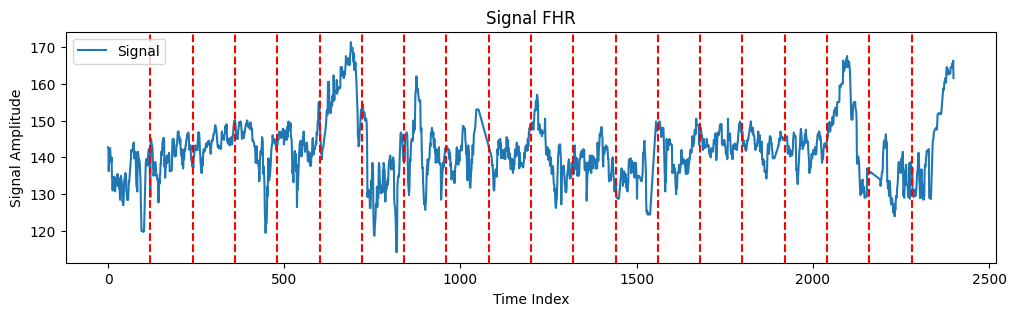

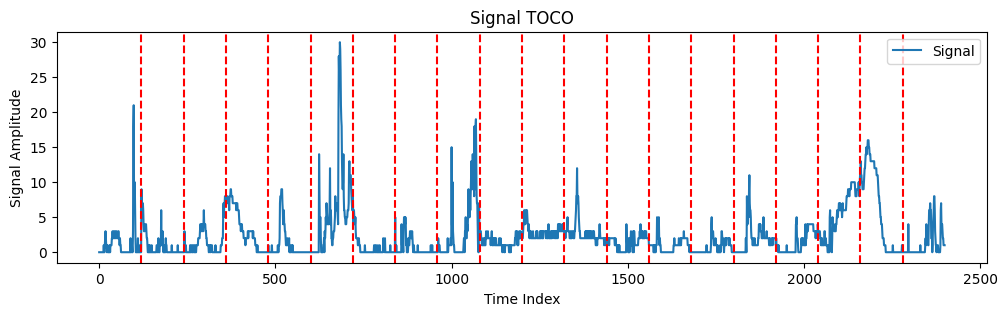

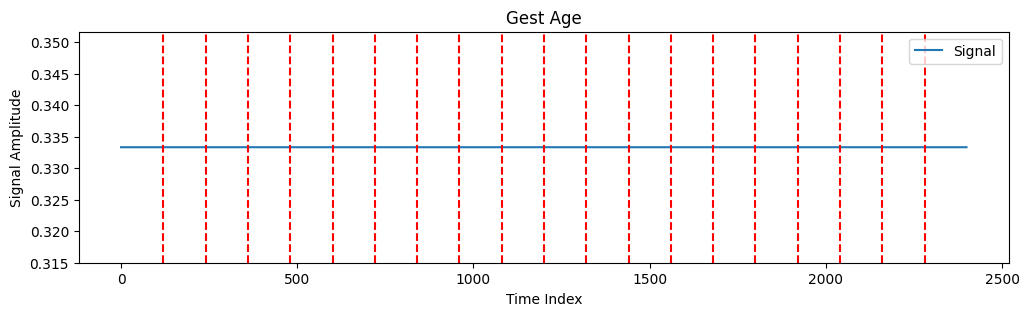

In [ ]:
num_slices=20

# Extract each signal
signal_fhr = instance_signal_2[:, 0]
signal_toco = instance_signal_2[:, 1]
signal_gest = instance_signal_2[:, 2]

# Plot each signal separately
signals = [signal_fhr, signal_toco, signal_gest]
titles = ["Signal FHR", "Signal TOCO", "Gest Age"]

from lime_explanation import segment_signal
from visualization import plot_segmented_signal

for idx, signal in enumerate(signals):
    slice_width = segment_signal(signal, num_slices)
    plot_segmented_signal(signal, slice_width, titles[idx])

##Algorithm

In [174]:
import numpy as np
from scipy.signal import resample

def aam_mantel(FHR, simpleacc=False):
    subsamphbi = avg_sub_samp(np.round(60000.0 / FHR), 10)
 # Heart beat interval: converts a heart rate given in beats per minute (bpm)
    #to the corresponding time interval in milliseconds. For example, a heart rate of 120 bpm
    #corresponds to an interval of:60000/120=500 milliseconds
    blsupport = baselineloop(subsamphbi)
    bl = filter_pass(subsamphbi, blsupport)
    bl = trim_rr(subsamphbi, bl, 20, 20)
    bl = filter_pass(bl, blsupport)
    bl = trim_rr(subsamphbi, bl, 15, 20)
    bl = filter_pass(bl, blsupport)
    bl = trim_rr(subsamphbi, bl, 10, 20)
    bl = filter_pass(bl, blsupport)
    bl = trim_rr(subsamphbi, bl, 5, 20)
    bl = filter_pass(bl, blsupport)

    baseline_fhr = 60000.0 / bl

    fhr0_subsamp = np.zeros_like(baseline_fhr)
    for i in range(len(fhr0_subsamp)):
        FHR0w = FHR[(i * 10):(i + 1) * 10]
        fhr0_subsamp[i] = np.mean(FHR0w[FHR0w > 0])

    fhr0_subsamp[np.isnan(fhr0_subsamp)] = 0
    fhr_subsamp = interpolate_fhr(fhr0_subsamp)

    s_acc = fhr_subsamp - baseline_fhr
    s_dec = baseline_fhr - fhr_subsamp

    accelerations = mantel_accident(s_acc, np.isnan(fhr0_subsamp), threshold=5)
    decelerations = mantel_accident(s_dec, np.isnan(fhr0_subsamp), threshold=5)

    baseline = resample(baseline_fhr, len(FHR))
    if simpleacc:
        accelerations, decelerations = simple_add_detection(FHR, baseline)

    return baseline, accelerations, decelerations



def avg_sub_samp(data, step): #Compute the average of `data` in chunks of `step` size.
    subsampled = []
    for i in range(0, len(data), step):
        subsampled.append(np.mean(data[i:i + step]))
    return np.array(subsampled)


def baselineloop(hbi):
    blsupport = np.zeros(len(hbi))
    window_size = 1536  # 64 minutes * 24 samples per minute

    if len(hbi) < window_size:
        blsupport[:] = base_level_reference(hbi)
    else:
        for i in range(0, len(hbi) - window_size + 1, window_size):
            blsupport[i:i + window_size] = base_level_reference(hbi[i:i + window_size])

        # Handle the last segment if it is less than the window size
        if len(hbi) % window_size != 0:
            last_start = len(hbi) - window_size
            blsupport[last_start:] = base_level_reference(hbi[last_start:])

    return blsupport


def base_level_reference(hbi): #Determine the base level reference from the histogram of heart beat intervals.
    hbi = np.round(hbi)  # Round values to nearest integers
    histogram = np.zeros(300)  # Initialize histogram with 300 bins

    # Populate histogram
    for value in hbi:
        if not np.isnan(value) and 300 < value <= 600:
            histogram[int(value) - 301] += 1

    # Normalize the histogram
    histogram /= np.sum(histogram)

    # Compute cumulative sum of the histogram
    cshist = np.cumsum(histogram)

    # Find the baseline value
    # Create a mask for the local maxima condition
    local_maxima_mask = (histogram[5:-1] > histogram[6:]) & \
                        (histogram[5:-1] > histogram[4:-2]) & \
                        (histogram[5:-1] > histogram[3:-3]) & \
                        (histogram[5:-1] > histogram[2:-4]) & \
                        (histogram[5:-1] > histogram[1:-5]) & \
                        (histogram[5:-1] > histogram[0:-6])

    # Combine with cumulative histogram condition
    mask = np.concatenate(([False]*5, local_maxima_mask, [False]))
    candidates = np.where((cshist <= 0.875) & mask)[0]

    if candidates.size > 0:
        p = candidates[-1] + 300
    else:
        p = np.argmax(histogram) + 300

    return p

def filter_pass(B, P):  #Apply a low-pass filter to the input array `B` using the reference array `P`.
    B0 = P[0]
    for i in range(len(B) - 1, -1, -1):
        if abs(B[i] - P[i]) <= 60:
            B0 = 0.95 * B0 + 0.05 * B[i]
    if abs(B[0] - P[0]) <= 60:
        B[0] = 0.95 * B0 + 0.05 * B[0]
    else:
        B[0] = B0
    for i in range(1, len(B)):
        if abs(B[i] - P[i]) <= 60:
            B[i] = 0.95 * B[i - 1] + 0.05 * B[i]
        else:
            B[i] = B[i - 1]
    for i in range(len(B) - 2, -1, -1):
        B[i] = 0.95 * B[i + 1] + 0.05 * B[i]
    return B

def trim_rr(A, B, U, L):

  '''
run 1: Primary application of the baseline filter;
run 2: Trimming at U = 20 bpm and L = 20 bpm, followed by application of the
baseline filter;
run 3: Same as run 2, except U = 15 bpm;
run 4: Same as run 2, except U = 10 bpm;
run 5: Same as run 2, except U = 5 bpm.
  '''
  blpoints = np.ones(len(A), dtype=int)

  A = 60000.0 / A
  B = 60000.0 / B

  i = 0
  while i < len(A):
      if A[i] > B[i] + U:
          d_candidates = np.where(A[:i] < B[:i])[0]
          d = d_candidates[-1] + 1 if d_candidates.size > 0 else 0 #Find the last index 𝑑 where A was less than B before index i
          f_candidates = np.where(A[d:] < B[d:])[0]
          f = f_candidates[0] + d - 1 if f_candidates.size > 0 else len(A) - 1. #Find the first index f after d where A was less than B
          blpoints[d:f + 1] = 0  # Adjust to match MATLAB indexing
          i = f + 1
      elif A[i] < B[i] - L:
          d_candidates = np.where(A[:i] > B[:i])[0]
          d = d_candidates[-1] + 1 if d_candidates.size > 0 else 0
          f_candidates = np.where(A[d:] > B[d:])[0]
          f = f_candidates[0] + d - 1 if f_candidates.size > 0 else len(A) - 1
          blpoints[d:f + 1] = 0  # Adjust to match MATLAB indexing
          i = f + 1
      else:
          i += 1

  B[blpoints == 1] = A[blpoints == 1]
  return 60000.0 / B

def interpolate_fhr(fhr): #Interpolate missing values in the FHR data.
    indices = np.where(fhr > 0)[0]
    fhr_interp = np.interp(np.arange(len(fhr)), indices, fhr[indices])
    return fhr_interp

def mantel_accident(s, signan, threshold): #Detect accelerations or decelerations based on the given signal and threshold.
    starts = np.where((s[:-1] < threshold) & (s[1:] >= threshold))[0] + 1
    ends = np.zeros_like(starts)
    valids = np.zeros_like(starts)

    for i in range(len(starts)):
        e_indices = np.where((s[starts[i]:] < threshold))[0]
        if e_indices.size > 0:
            ends[i] = starts[i] + e_indices[0]
        else:
            ends[i] = len(s)
        valids[i] = (ends[i] - starts[i] >= 5) and np.any(s[starts[i]:ends[i]] > 10)

    valid_accidents = []
    for i in range(len(starts)):
        if valids[i]:
            valid_accidents.append((starts[i], ends[i]))

    return np.array(valid_accidents) * 2.5

import numpy as np
from scipy.signal import find_peaks

def simple_add_detection(fhr, baseline):
    # Compute accelerations and decelerations
    acc = detect_accident(fhr - baseline, 15)
    dec = detect_accident(baseline - fhr, 15)

    # Compute false positives
    false_acc = minus_int(acc, detect_accident(fhr - baseline, 5))
    false_dec = minus_int(dec, detect_accident(baseline - fhr, 5))

    return acc, dec

import numpy as np

def detect_accident(sig, thre):
    # Find indices where signal exceeds the threshold
    peaks = np.where(sig > thre)[0]
    accidents_sample = np.empty((3, 0), dtype=float)

    while peaks.size > 0:
        # Find the last point before the peak where the signal is less than zero
        dacc = np.where(sig[:peaks[0]] < 0)[0]
        if dacc.size == 0:
            dacc = 0
        else:
            dacc = dacc[-1]

        # Find the first point after the start of the accident where the signal is less than zero
        facc = np.where(sig[dacc+1:] < 0)[0]
        if facc.size == 0:
            facc = len(sig) - 1
        else:
            facc = facc[0] + dacc + 1

        # Find the maximum value within the accident range
        macc = np.argmax(sig[dacc:facc+1]) + dacc

        # If the duration of the accident is greater than 15 * 4, add it to accidents_sample
        if (facc - dacc) > 15 * 4:
            accidents_sample = np.hstack((accidents_sample, np.array([[dacc / 4], [facc / 4], [macc / 4]])))

        # Remove peaks that are within the identified accident range
        peaks = peaks[peaks > facc]

    return accidents_sample


def minus_int(a, f):
    # Remove intervals in `a` that are covered by intervals in `f`
    valid_indices = []
    for i in range(a.shape[1]):
        valid = np.all((f[0, :] < a[1, i]) | (f[1, :] > a[0, i]))
        if valid:
            valid_indices.append(i)

    return a[:, valid_indices] if valid_indices else np.empty((3, 0))





In [157]:
from scipy.signal import resample

baseline = []
accelerations = []
decelerations = []
baseline_2Hz = []
accelerations_2Hz = []
decelerations_2Hz = []

for i in range(3):
  # Assume instance_signal is your input fetal heart rate data sampled at 2Hz
  ins = instance_signal_2[:,i]

# Create an upsampled version of FHR for processing at 4Hz
#instance_signal_4Hz = np.repeat(ins, 2) #np.repeat creates [1 1 2 2 3 3 4 4] from [1,2,3,4]


# Resample to 4Hz (length should be doubled), scipy.signal.resample performs resampling by applying Fourier method, which can provide smoother results compared to np.repeat.

  instance_signal_4Hz = resample(ins, len(ins) * 2)


# Call the aam_mantel function
  baseline, accelerations, decelerations = aam_mantel(instance_signal_4Hz, simpleacc=True)


# Downsample the baseline back to 2Hz
  baseline_2Hz.append( baseline[::2] )
  accelerations_2Hz.append(accelerations*2)
  decelerations_2Hz.append(decelerations*2)


# Display the results
  print("Baseline at 2Hz:", baseline_2Hz)
  print("Accelerations:", accelerations_2Hz)
  print("Decelerations:", decelerations_2Hz)

"""
OUTPUT
baseline  : the baseline signal at 4Hz
accelerations : Table with begining and end of each accelerations in s in each column
decelerations : Table with begining and end of each decelerations in s in each column

"""

Baseline at 2Hz: [array([137.83496391, 137.74811412, 137.71820964, ..., 138.34863541,
       138.15520615, 137.97579167])]
Accelerations: [array([[ 611. ,  858.5, 1182.5, 2029.5, 2338. ],
       [ 735.5,  890.5, 1243.5, 2125. , 2399.5],
       [ 689. ,  875.5, 1217. , 2096.5, 2398.5]])]
Decelerations: [array([[735. ],
       [800.5],
       [755.5]])]
Baseline at 2Hz: [array([137.83496391, 137.74811412, 137.71820964, ..., 138.34863541,
       138.15520615, 137.97579167]), array([200., 200., 200., ..., 200., 200., 200.])]
Accelerations: [array([[ 611. ,  858.5, 1182.5, 2029.5, 2338. ],
       [ 735.5,  890.5, 1243.5, 2125. , 2399.5],
       [ 689. ,  875.5, 1217. , 2096.5, 2398.5]]), array([], shape=(3, 0), dtype=float64)]
Decelerations: [array([[735. ],
       [800.5],
       [755.5]]), array([[   0. ],
       [2399.5],
       [ 622.5]])]
Baseline at 2Hz: [array([137.83496391, 137.74811412, 137.71820964, ..., 138.34863541,
       138.15520615, 137.97579167]), array([200., 200., 200., .

<ipython-input-70-216f50fd257f>:5: RuntimeWarning: divide by zero encountered in divide
  subsamphbi = avg_sub_samp(np.round(60000.0 / FHR), 10)
<ipython-input-70-216f50fd257f>:79: RuntimeWarning: invalid value encountered in divide
  histogram /= np.sum(histogram)


'\nOUTPUT\nbaseline  : the baseline signal at 4Hz\naccelerations : Table with begining and end of each accelerations in s in each column\ndecelerations : Table with begining and end of each decelerations in s in each column\n\n'

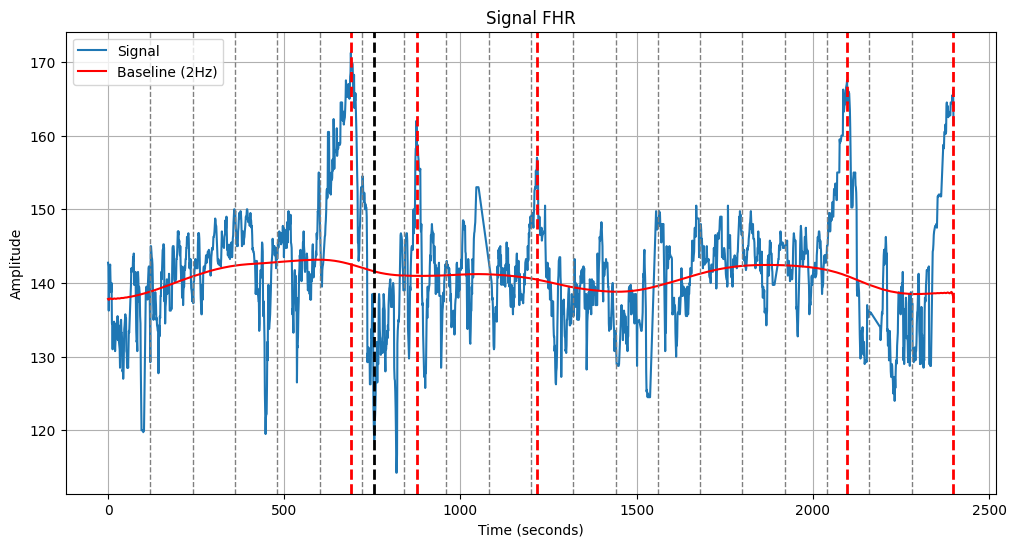

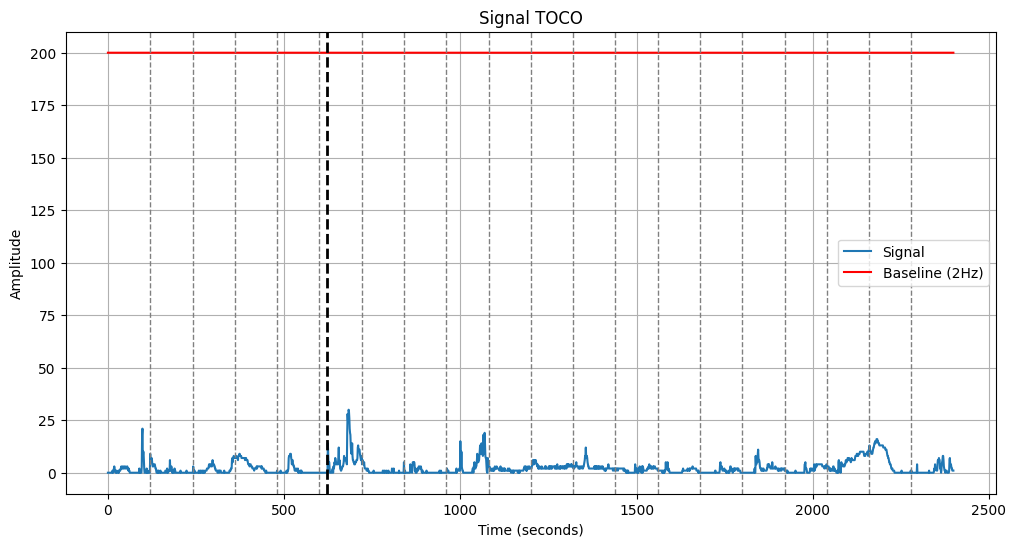

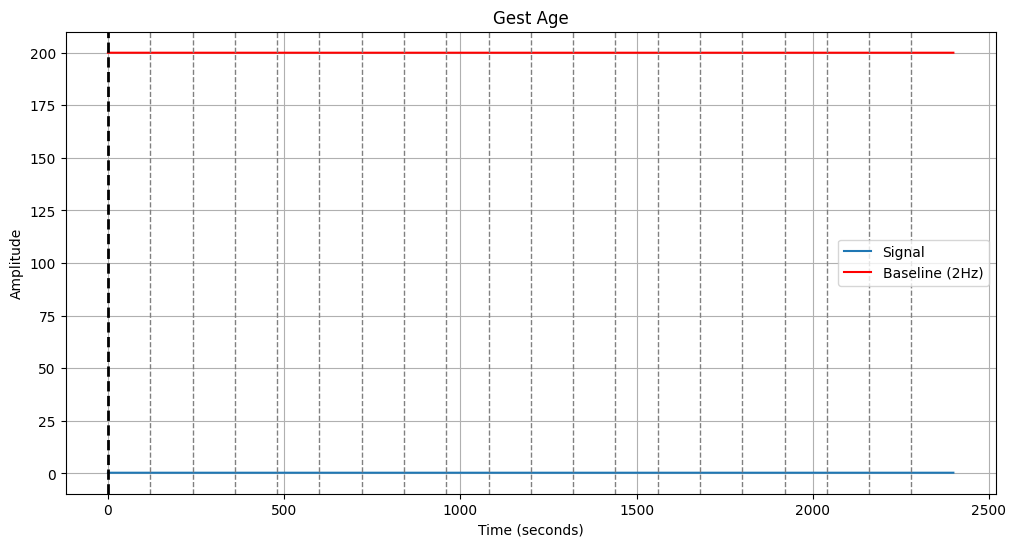

In [173]:
# Her sinyal için ayrı grafikler oluşturma

num_slices=20

# Extract each signal
signal_fhr = instance_signal_2[:, 0]
signal_toco = instance_signal_2[:, 1]
signal_gest = instance_signal_2[:, 2]

# Plot each signal separately
signals = [signal_fhr, signal_toco, signal_gest]
titles = ["Signal FHR", "Signal TOCO", "Gest Age"]

from lime_explanation import segment_signal
from visualization import plot_segmented_signal

# Her sinyal için ayrı grafik oluşturma
for idx, signal in enumerate(signals):
    slice_width = len(signal) // num_slices

    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='Signal')
    plt.plot(baseline_2Hz[idx], label='Baseline (2Hz)', color='red')

    # Segment çizgilerini ekleyin
    for i in range(1, num_slices):
        plt.axvline(x=i * slice_width, color='gray', linestyle='--', linewidth=1)

    # Hızlanma olaylarını çizme
    acc_array = accelerations_2Hz[idx]
    if acc_array.size > 0:  # Check if the array is not empty
        for i in range(acc_array.shape[1]):  # Iterate over the second dimension (columns)
            plt.axvline(x=acc_array[2, i], color='r', linestyle='--', linewidth=2)

    # Yavaşlama olaylarını çizme
    dec_array = decelerations_2Hz[idx]
    if dec_array.size > 0 and dec_array.shape[1] > 0:  # Check if the array is not empty and has columns
        for i in range(dec_array.shape[1]):  # Iterate over the second dimension (columns)
            plt.axvline(x=dec_array[2, i], color='black', linestyle='--', linewidth=2)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(titles[idx])
    plt.legend()
    plt.grid(True)
    plt.show()

In [170]:
dec_array

array([0.])

##FHR

In [270]:
# Assume instance_signal is your input fetal heart rate data sampled at 2Hz
ins = instance_signal_2[:,0]

# Create an upsampled version of FHR for processing at 4Hz
#instance_signal_4Hz = np.repeat(ins, 2) #np.repeat creates [1 1 2 2 3 3 4 4] from [1,2,3,4]


# Resample to 4Hz (length should be doubled), scipy.signal.resample performs resampling by applying Fourier method, which can provide smoother results compared to np.repeat.
from scipy.signal import resample
instance_signal_4Hz = resample(ins, len(ins) * 2)


# Call the aam_mantel function
baseline, accelerations, decelerations = aam_mantel(instance_signal_4Hz, simpleacc=True)


# Downsample the baseline back to 2Hz
baseline_2Hz = baseline[::2]
accelerations_2Hz = accelerations*2
decelerations_2Hz = decelerations*2


# Display the results
print("Baseline at 2Hz:", baseline_2Hz)
print("Accelerations:", accelerations_2Hz)
print("Decelerations:", decelerations_2Hz)

"""
OUTPUT
baseline  : the baseline signal at 4Hz
accelerations : Table with begining and end of each accelerations in s in each column
decelerations : Table with begining and end of each decelerations in s in each column

"""


Baseline at 2Hz: [137.83496391 137.74811412 137.71820964 ... 138.34863541 138.15520615
 137.97579167]
Accelerations: [[ 611.   858.5 1182.5 2029.5 2338. ]
 [ 735.5  890.5 1243.5 2125.  2399.5]
 [ 689.   875.5 1217.  2096.5 2398.5]]
Decelerations: [[735. ]
 [800.5]
 [755.5]]


'\nOUTPUT\nbaseline  : the baseline signal at 4Hz\naccelerations : Table with begining and end of each accelerations in s in each column\ndecelerations : Table with begining and end of each decelerations in s in each column\n\n'

In [254]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segmented_signal_(instance_sig, slice_width, title):
    """
    Plots the signal and its segments, and returns the figure and axis objects.

    Parameters:
        instance_sig (np.ndarray): The signal instance to plot.
        slice_width (int): The width of each slice in the segmented signal.
        title (str): Title for the plot.

    Returns:
        fig (matplotlib.figure.Figure): The figure object.
        ax (matplotlib.axes._axes.Axes): The axis object.
    """
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(instance_sig, label='Signal')

    num_slices = len(instance_sig) // slice_width

    for i in range(1, num_slices):
        ax.axvline(x=i * slice_width, color='grey', linestyle='--')

    ax.set_title(title)
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Signal Amplitude')
    ax.legend()

    return fig, ax


In [267]:
accelerations_2Hz

array([[ 611,  858, 1182, 2029, 2338],
       [ 735,  890, 1243, 2125, 2399],
       [ 689,  875, 1217, 2096, 2398]])

<Figure size 1200x600 with 0 Axes>

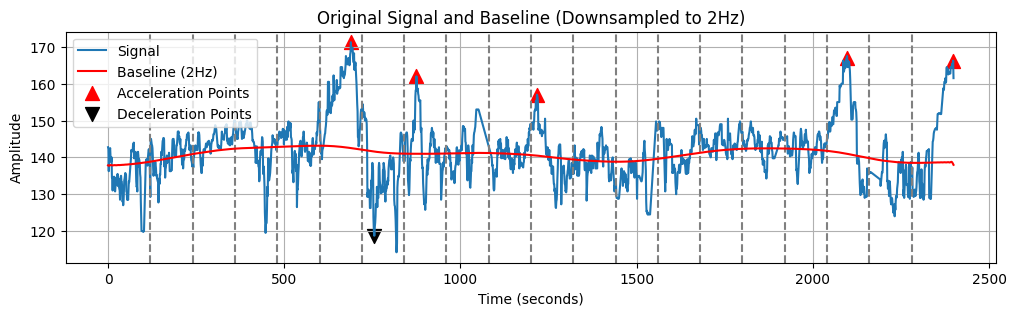

"\nfor i in range(len(accelerations_2Hz[2])):\n  plt.axvline(x=accelerations_2Hz[2][i], color='red', linestyle='--', linewidth=2)\nfor i in range(len(decelerations_2Hz[2])):\n  plt.axvline(x=decelerations_2Hz[2][i], color='black', linestyle='--', linewidth=2)\n\n"

In [271]:
from lime_explanation import segment_signal
from visualization import plot_segmented_signal


#Plot the original signal and the downsampled baseline
plt.figure(figsize=(12, 6))

fig, ax = plot_segmented_signal_(ins, segment_signal(ins, num_slices), 'FHR')

# Plot downsampled baseline
ax.plot(baseline_2Hz,  label='Baseline (2Hz)', color='red')

# İndekslerin tam sayı olduğundan emin olalım
acc = np.array(accelerations_2Hz[2], dtype=int)
dec = np.array(decelerations_2Hz[2], dtype=int)

# Scatter plot ile noktaları ekleyelim
ax.scatter(acc, ins[acc], color='red', label='Acceleration Points', marker='^', s=100)
ax.scatter(dec, ins[dec], color='black', label='Deceleration Points', marker='v', s=100)

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Original Signal and Baseline (Downsampled to 2Hz)')
plt.legend()
plt.grid(True)

plt.show()


'''
for i in range(len(accelerations_2Hz[2])):
  plt.axvline(x=accelerations_2Hz[2][i], color='red', linestyle='--', linewidth=2)
for i in range(len(decelerations_2Hz[2])):
  plt.axvline(x=decelerations_2Hz[2][i], color='black', linestyle='--', linewidth=2)

'''

##TOCO

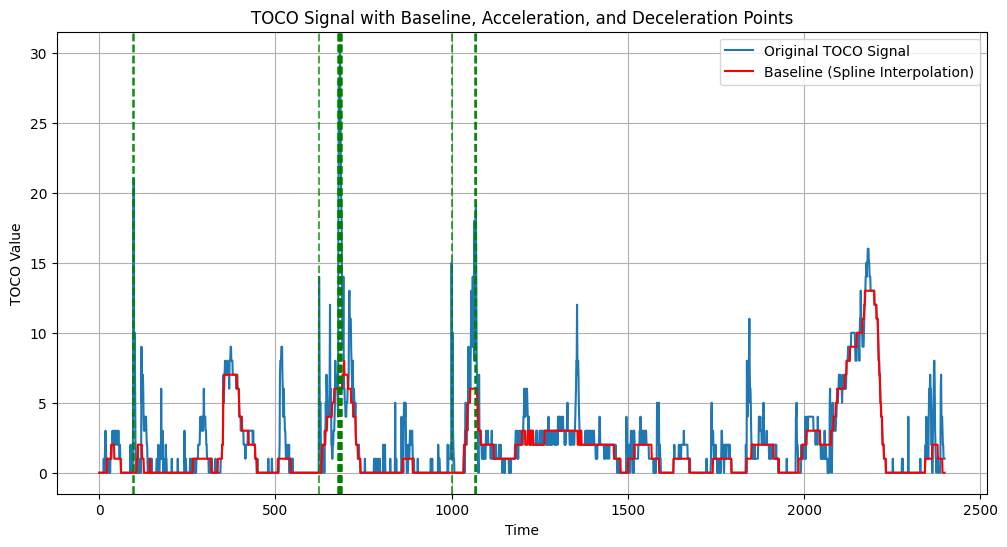

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.interpolate import UnivariateSpline

# TOCO verilerini ve akselerasyon/dekselerasyon noktalarını tanımlayan fonksiyonlar
def calculate_toco_baseline(toco_data, window_size=51):
    # Medyan filtre uygulama
    smoothed_toco = medfilt(toco_data, kernel_size=window_size)

    # Baseline hesaplama için spline interpolasyonu
    x = np.arange(len(smoothed_toco))
    spline = UnivariateSpline(x, smoothed_toco, s=0)
    baseline = spline(x)

    return baseline

def detect_acceleration_deceleration_points(signal, baseline, threshold_acc, threshold_dec):
    acc_points = np.where(signal - baseline > threshold_acc)[0]
    dec_points = np.where(baseline - signal > threshold_dec)[0]
    return acc_points, dec_points

toco_data = instance_signal_2[:,1]
# Baseline hesaplama
baseline = calculate_toco_baseline(toco_data)

# Akselerasyon ve dekselerasyon noktalarını bulma
threshold_acc = 10
threshold_dec = 10
acc_points, dec_points = detect_acceleration_deceleration_points(toco_data, baseline, threshold_acc, threshold_dec)

# Grafik oluşturma
plt.figure(figsize=(12, 6))
plt.plot(toco_data, label='Original TOCO Signal')
plt.plot(baseline, label='Baseline (Spline Interpolation)', color='red')


# Kesikli çizgilerle akselerasyon ve dekselerasyon noktalarını vurgulama
for point in acc_points:
    plt.axvline(x=point, color='green', linestyle='--', alpha=0.7)
for point in dec_points:
    plt.axvline(x=point, color='blue', linestyle='--', alpha=0.7)

plt.legend()
plt.xlabel('Time')
plt.ylabel('TOCO Value')
plt.title('TOCO Signal with Baseline, Acceleration, and Deceleration Points')
plt.grid(True)
plt.show()


#ModelFederica


In [ ]:
!unzip /content/finalModel.zip

Archive:  /content/finalModel.zip
 extracting: finalModel/keras_metadata.pb  
   creating: finalModel/assets/
 extracting: finalModel/variables/variables.data-00000-of-00001  
 extracting: finalModel/variables/variables.index  
 extracting: finalModel/saved_model.pb  


In [ ]:
model= tf.saved_model.load('/content/finalModel')


#LIME_TimeSeries


In [ ]:
tp = []
tn = []
fp = []
fn = []

prob = model(test_data_tensor)
predicted_label = np.round(prob)

for i in range(len(y_test_tensor)):
  if y_test_tensor[i] == predicted_label[i] == 1. :
    tp.append(i)
  elif y_test_tensor[i] == predicted_label[i] == 0. :
    tn.append(i)
  elif y_test_tensor[i] != predicted_label[i] and y_test_tensor[i] == 1. :
    fn.append(i)
  elif y_test_tensor[i] != predicted_label[i] and y_test_tensor[i] == 0. :
    fp.append(i)
print("TP:", tp)
print("TN:", tn)
print("FP:", fp)
print("FN:", fn)



TP: [6, 7, 8, 21, 22, 23, 24, 25, 26, 45, 46, 47, 48, 49, 50, 72, 73, 74, 88, 89, 90, 97, 98, 99, 100, 101, 102, 116, 117, 118, 122, 124]
TN: [0, 1, 2, 3, 4, 5, 9, 10, 11, 15, 16, 33, 36, 37, 38, 39, 40, 41, 51, 52, 53, 54, 55, 60, 61, 62, 63, 64, 65, 66, 67, 76, 77, 78, 79, 80, 81, 82, 83, 84, 91, 112, 113, 114, 115, 119, 120, 121]
FP: [12, 13, 14, 17, 18, 19, 20, 30, 31, 32, 34, 35, 42, 43, 44, 56, 57, 58, 59, 68, 69, 70, 71, 92, 93, 94, 95, 96, 106, 107, 108, 109, 110, 111]
FN: [27, 28, 29, 75, 85, 86, 87, 103, 104, 105, 123, 125, 126, 127]


In [ ]:
pathological_ins = []
healty_ins = []
for i in range(len(y_test_tensor)):
  if predicted_label[i] == 1. :
    pathological_ins.append(i)
  elif predicted_label[i] == 0. :
    healty_ins.append(i)
print("healthy instances predicted:", healty_ins)
print("pathological instances predicted:", pathological_ins)


healthy instances predicted: [0, 1, 2, 3, 4, 5, 9, 10, 11, 15, 16, 27, 28, 29, 33, 36, 37, 38, 39, 40, 41, 51, 52, 53, 54, 55, 60, 61, 62, 63, 64, 65, 66, 67, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 91, 103, 104, 105, 112, 113, 114, 115, 119, 120, 121, 123, 125, 126, 127]
pathological instances predicted: [6, 7, 8, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 56, 57, 58, 59, 68, 69, 70, 71, 72, 73, 74, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 106, 107, 108, 109, 110, 111, 116, 117, 118, 122, 124]


In [ ]:
pathological_label = []
healty_label = []
for i in range(len(y_test_tensor)):
  if y_test_tensor[i] == 1. :
    pathological_label.append(i)
  elif y_test_tensor[i] == 0. :
    healty_label.append(i)
print("healthy instances :", healty_label)
print("pathological instances :", pathological_label)

healthy instances : [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 79, 80, 81, 82, 83, 84, 91, 92, 93, 94, 95, 96, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 119, 120, 121]
pathological instances : [6, 7, 8, 21, 22, 23, 24, 25, 26, 27, 28, 29, 45, 46, 47, 48, 49, 50, 72, 73, 74, 75, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 116, 117, 118, 122, 123, 124, 125, 126, 127]


In [ ]:
print("%",np.round((np.count_nonzero(predicted_label)/predicted_label.shape[0])*100), "percent of test data is predicted as pathological" )

% 52.0 percent of test data is predicted as pathological


In [ ]:
import sys
# Update the path below according to your project structure
sys.path.append('../src')

In [ ]:
# Create the probability vector for each instances in test dataset
probability_vectors = model(test_data_tensor)
probability_vectors

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.05984734],
       [0.24451205],
       [0.21692182],
       [0.11608379],
       [0.2606317 ],
       [0.43851668],
       [0.99816054],
       [0.9872677 ],
       [0.8538456 ],
       [0.020975  ],
       [0.19382489],
       [0.22547626],
       [0.84869516],
       [0.96081394],
       [0.98482287],
       [0.44128507],
       [0.31839117],
       [0.7631759 ],
       [0.904506  ],
       [0.74997747],
       [0.66847897],
       [0.71270996],
       [0.7374802 ],
       [0.7065938 ],
       [0.937082  ],
       [0.99957556],
       [0.9981077 ],
       [0.13262616],
       [0.02394691],
       [0.00410331],
       [0.8736104 ],
       [0.58385724],
       [0.7786633 ],
       [0.3620055 ],
       [0.51836246],
       [0.71383524],
       [0.39126992],
       [0.19814716],
       [0.1739525 ],
       [0.19947   ],
       [0.07725386],
       [0.03410392],
       [0.9408168 ],
       [0.95986205],
       [0.8319427 ],
     

In [ ]:
id = 105        # Just for an example: choose an index from rows
instance_signal = test_data_tensor[id, :]     # Extract the selected instance from the test dataset
print("Shape of instance_signal:", instance_signal.shape)  # Check the shape of the selected instance

Shape of instance_signal: (2400, 3)


##Deneme

##Let's get one sample from each

In [ ]:
# Predict the class of the selected signal by trained model
probability_vector = model(instance_signal[np.newaxis, :])
print("Probability vector of the selected instance:", probability_vector)

Probability vector of the selected instance: tf.Tensor([[0.31395432]], shape=(1, 1), dtype=float32)


In [ ]:
#class labels
class_labels = [0, 1]
#Import and call the analyze_prediction function
from lime_explanation import analyze_prediction

probability_vector = probability_vector.numpy()
top_pred_classes, predicted_class = analyze_prediction(probability_vector, class_labels)

print("Top predicted classes:", top_pred_classes)
print("Predicted Class for the selected instance:", predicted_class)

Top predicted classes: [0]
Predicted Class for the selected instance: 0


In [ ]:
from lime_explanation import segment_signal, generate_random_perturbations
from visualization import plot_segmented_signal

In [ ]:
instance_signal

<tf.Tensor: shape=(2400, 3), dtype=float32, numpy=
array([[ 0.3866634 , -2.5114627 ,  0.33333334],
       [ 0.32174626, -2.5114627 ,  0.33333334],
       [-0.45725965, -2.5114627 ,  0.33333334],
       ...,
       [ 3.1781013 , -2.3666785 ,  0.33333334],
       [ 3.43777   , -2.3666785 ,  0.33333334],
       [ 2.8210568 , -2.3666785 ,  0.33333334]], dtype=float32)>

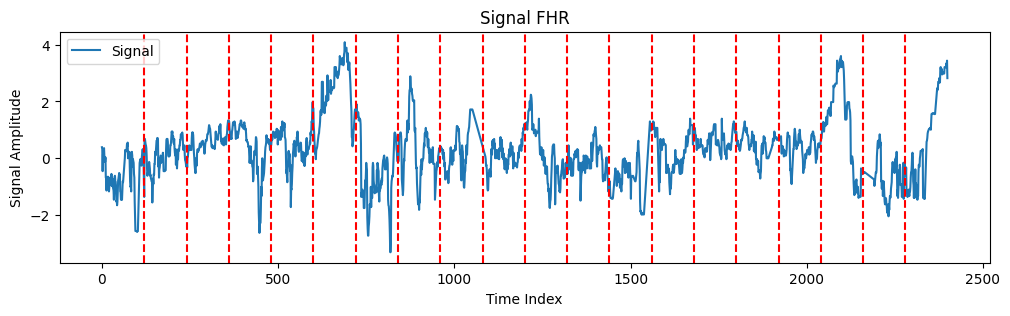

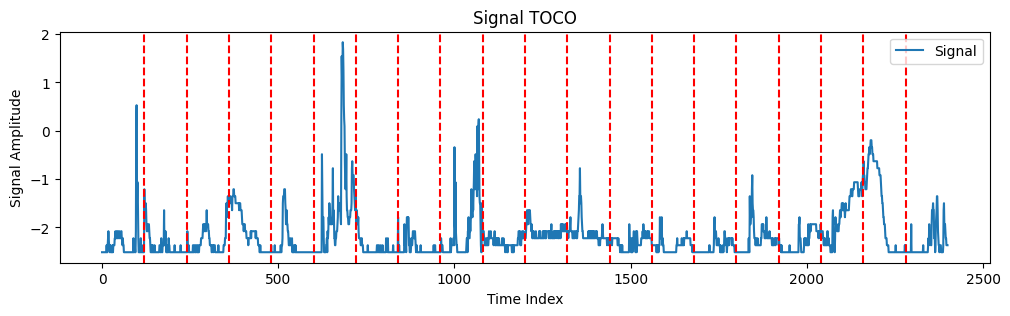

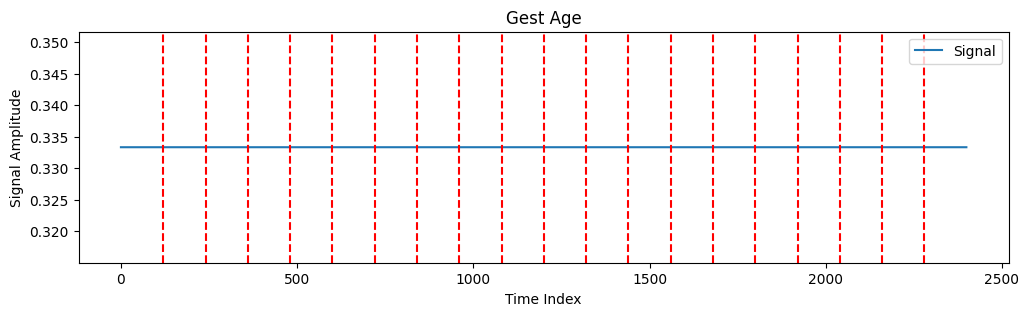

In [ ]:
# Convert TensorFlow tensor to NumPy array
signal_array = instance_signal.numpy()
num_slices=20

# Extract each signal
signal_1 = signal_array[:, 0]
signal_2 = signal_array[:, 1]
signal_3 = signal_array[:, 2]

# Plot each signal separately
signals = [signal_1, signal_2, signal_3]
titles = ["Signal FHR", "Signal TOCO", "Gest Age"]

for idx, signal in enumerate(signals):
    slice_width = segment_signal(signal, num_slices)
    plot_segmented_signal(signal, slice_width, titles[idx])

In [ ]:
# Perturbation
num_perturbations = 150
random_perturbations = generate_random_perturbations(num_perturbations, num_slices)

# Example output
print("The shape of random_perturbations array (num_perturbations, num_slices):", random_perturbations.shape)
print("Example Perturbation:", random_perturbations[-1])

The shape of random_perturbations array (num_perturbations, num_slices): (150, 20)
Example Perturbation: [1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0]


In [ ]:
#Convert instance from tensor to numpy
instance_signal = instance_signal.numpy()

In [ ]:
# Apply the Perturbation to the ECG signal and Display
from lime_explanation import apply_perturbation_to_signal, perturb_mean, perturb_noise, perturb_total_mean
from visualization import plot_perturbed_signal


In [ ]:
def plot_perturbed_signal(original_sig, perturbed_sig, perturbation, num_slices, title='Signal with Perturbation'):
    """
    Plots the original and perturbed  signals with slices and deactivated segments highlighted for each channel.

    Parameters:
    - original_sig (np.ndarray): The original  signal, should be a 2D array with shape (num_samples, num_channels).
    - perturbed_sig (np.ndarray): The perturbed  signal after applying the perturbation, should be a 2D array with shape (num_samples, num_channels).
    - perturbation (np.ndarray): The perturbation vector used to modify the  signal, should be a 1D array with length num_slices.
    - num_slices (int): The total number of segments the  signal is divided into.
    - title (str): The title for the plot. Optional.
    """
    num_channels = original_sig.shape[1]
    total_length = original_sig.shape[0]
    slice_width = total_length // num_slices

    plt.figure(figsize=(15, 4 * num_channels))
    channel_labels = ['FHR', 'TOCO', 'Gest Age']

    for ch in range(num_channels):
        # Plot original  signal with slices and deactivated segments highlighted
        plt.subplot(num_channels, 2, 2 * ch + 1)
        plt.plot(original_sig[:, ch], label='Original Signal', color='black')
        plt.title(f'Original Signal - {channel_labels[ch]}')
        for i in range(num_slices):
            start_idx = i * slice_width
            end_idx = min((i + 1) * slice_width, total_length)
            plt.axvline(x=start_idx, color='r', linestyle='--', alpha=0.5)  # Slice boundary
            if perturbation[i] == 0:  # If the segment is "off" in the perturbation
                plt.axvspan(start_idx, end_idx, color='red', alpha=0.3)  # Highlight deactivated segment
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        # Plot perturbed  signal with slices and deactivated segments highlighted
        plt.subplot(num_channels, 2, 2 * ch + 2)
        plt.plot(perturbed_sig[:, ch], label='Perturbed Signal', color='green')
        plt.title(f'Perturbed {title} - {channel_labels[ch]}')
        for i in range(num_slices):
            start_idx = i * slice_width
            end_idx = min((i + 1) * slice_width, total_length)
            plt.axvline(x=start_idx, color='r', linestyle='--', alpha=0.5)  # Slice boundary
            if perturbation[i] == 0:  # If the segment is "off" in the perturbation
                plt.axvspan(start_idx, end_idx, color='red', alpha=0.3)  # Highlight deactivated segment
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


In [ ]:
'''

def apply_perturbation_to_signal(signal, perturbation, num_segments, perturb_function=perturb_mean):
    """
    Apply a perturbation to a multi-channel signal.

    Parameters:
    - signal (np.ndarray): The original signal with shape (length, channels).
    - perturbation (np.ndarray): A vector indicating which segments to turn on (1) or off (0).
    - num_segments (int): The total number of segments the signal is divided into.
    - perturb_function (function): The function to use for perturbing the signal (default is perturb_mean).

    Returns:
    - np.ndarray: A perturbed version of the signal.
    """
    # Copy the signal to avoid modifying the original
    perturbed_signal = signal.copy()
    segment_length = len(signal) // num_segments

    # Apply the perturbation based on the provided vector
    for i, active in enumerate(perturbation):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length
        # Apply perturbation function only to "off" segments
        if not active:
            for channel in range(signal.shape[1]):
                perturbed_signal[:, channel] = perturb_function(perturbed_signal[:, channel], start_idx, end_idx)

    return perturbed_signal

    '''


'\n\ndef apply_perturbation_to_signal(signal, perturbation, num_segments, perturb_function=perturb_mean):\n    """\n    Apply a perturbation to a multi-channel signal.\n\n    Parameters:\n    - signal (np.ndarray): The original signal with shape (length, channels).\n    - perturbation (np.ndarray): A vector indicating which segments to turn on (1) or off (0).\n    - num_segments (int): The total number of segments the signal is divided into.\n    - perturb_function (function): The function to use for perturbing the signal (default is perturb_mean).\n\n    Returns:\n    - np.ndarray: A perturbed version of the signal.\n    """\n    # Copy the signal to avoid modifying the original\n    perturbed_signal = signal.copy()\n    segment_length = len(signal) // num_segments\n\n    # Apply the perturbation based on the provided vector\n    for i, active in enumerate(perturbation):\n        start_idx = i * segment_length\n        end_idx = start_idx + segment_length\n        # Apply perturbation

In [ ]:
def perturb_random_noise(signal, start_idx, end_idx):
    """
    Perturbs a segment of the signal by replacing it with random noise within the signal segment's range.

    Parameters:
        signal (np.ndarray): The original signal to perturb.
        start_idx (int): The starting index of the segment to perturb.
        end_idx (int): The ending index of the segment to perturb.

    Returns:
        np.ndarray: The signal with the specified segment perturbed by random noise.
    """
    modified_signal = signal.copy()

    # Calculate the min and max of the segment to perturb
    segment = signal[start_idx:end_idx]
    min_val = segment.min()
    max_val = segment.max()

    # Generate random noise within the range of the segment
    noise = np.random.uniform(min_val, max_val, size=end_idx - start_idx)

    # Replace the segment with random noise
    modified_signal[start_idx:end_idx] = noise

    return modified_signal


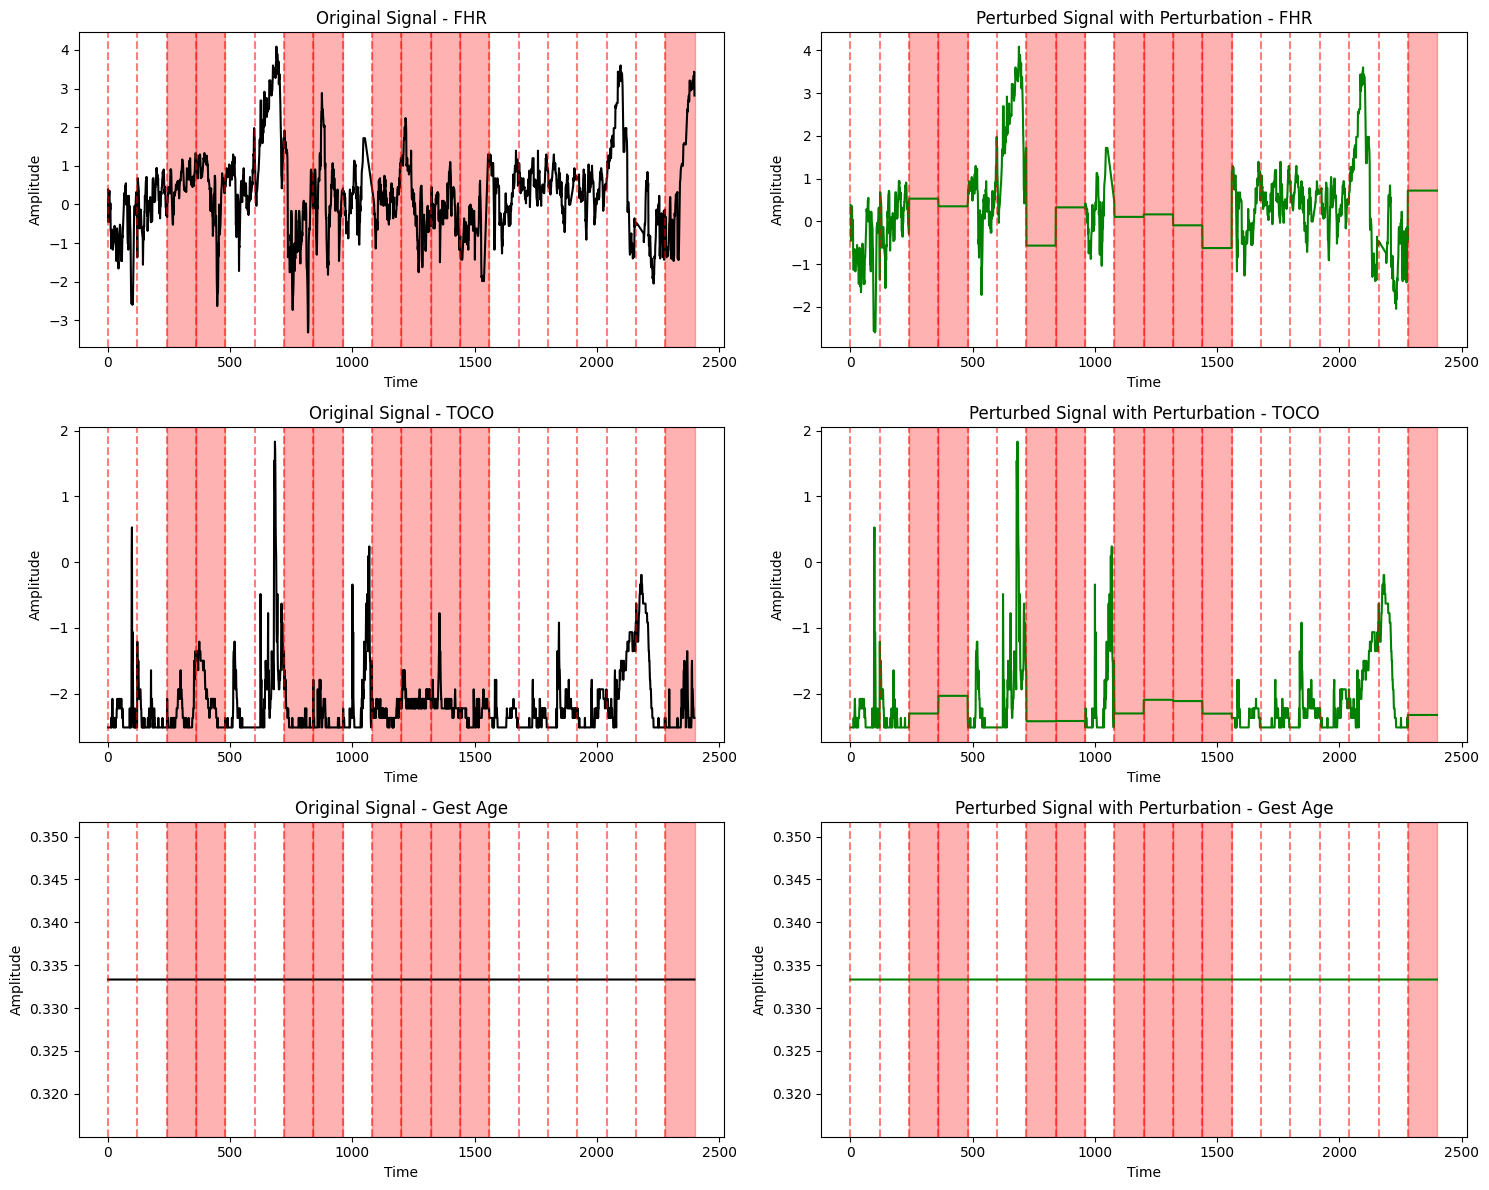

In [ ]:
# Choose the perturbation function
perturb_function = perturb_mean

# Apply a random perturbation to the ECG signal
perturbed_signal_example = apply_perturbation_to_signal(instance_signal, random_perturbations[-1], num_slices, perturb_function)

# plot the original and perturbed ECG signals with highlighted slices and deactivated segments
plot_perturbed_signal(instance_signal, perturbed_signal_example, random_perturbations[-1], num_slices, title='Signal with Perturbation')

In [ ]:
def predict_perturbations_channels_(model, instance_sig, random_perturbations, num_slices, perturb_function):
    """
    Applies a set of perturbations to an ECG signal, predicts the class probabilities for each perturbed signal,
    and collects the predictions.

    Parameters:
    - model: The trained classifier model.
    - instance_sig (np.ndarray): The original signal instance.
    - random_perturbations (np.ndarray): An array of perturbation vectors.
    - num_slices (int): The total number of segments the ECG signal is divided into.
    - perturb_function (function): The function to use for perturbing the signal (e.g., perturb_random_noise).

    Returns:
    - np.ndarray: An array of model predictions for each perturbed ECG signal.
    """
    perturbation_predictions = []

    for perturbation in random_perturbations:
        # Apply the current perturbation to the signal
        perturbed_signal = apply_perturbation_to_signal(instance_sig, perturbation, num_slices, perturb_function)

        '''
        #for debugging: Print the shape and sample of perturbed_signal
        print("Perturbed Signal Shape:", perturbed_signal.shape)
        print("Perturbed Signal Sample:", perturbed_signal[:5])
    '''
        # Reshape as required by the model
        perturbed_signal_reshaped = perturbed_signal.reshape(1, perturbed_signal.shape[0], perturbed_signal.shape[1])

        '''
        #for debugging
        print("Perturbed Signal Reshaped Shape:", perturbed_signal_reshaped.shape)
        print("Perturbed Signal Reshaped Sample:", perturbed_signal_reshaped[:5])
        '''

        # Predict the class probabilities
        model_prediction = model(perturbed_signal_reshaped)

        # Debug: Check for NaN values in model_prediction
        if np.isnan(model_prediction).any():
            raise ValueError("Model prediction contains NaN values")

        perturbation_predictions.append(model_prediction)

    # Convert the list of predictions into a numpy array
    perturbation_predictions = np.array(perturbation_predictions)
    return perturbation_predictions

# Example usage (assuming apply_perturbation_to_signal and perturb_random_noise are defined)
perturbation_predictions = predict_perturbations_channels_(model, instance_signal, random_perturbations, num_slices, perturb_random_noise)


In [ ]:
def predict_perturbations_channels(model, instance_sig, random_perturbations, num_slices, perturb_function):
    """
    Applies a set of perturbations to an ECG signal, predicts the class probabilities for each perturbed signal,
    and collects the predictions.

    Parameters:
    - model: The trained classifier model.
    - instance_sig (np.ndarray): The original signal instance.
    - random_perturbations (np.ndarray): An array of perturbation vectors.
    - num_slices (int): The total number of segments the ECG signal is divided into.
    - perturb_function (function): The function to use for perturbing the signal (e.g., perturb_mean).

    Returns:
    - np.ndarray: An array of model predictions for each perturbed ECG signal.
    """
    perturbation_predictions = []

    for perturbation in random_perturbations:
        # Apply the current perturbation to the ECG signal
        perturbed_signal = apply_perturbation_to_signal(instance_sig, perturbation, num_slices, perturb_function)

        # Reshape as required by the model
        perturbed_signal_reshaped = perturbed_signal.reshape(1, perturbed_signal.shape[0], perturbed_signal.shape[1])  # (1, 2400, 3)

        # Predict the class probabilities
        model_prediction = model(perturbed_signal_reshaped)
        perturbation_predictions.append(model_prediction)

    # Convert the list of predictions into a numpy array
    perturbation_predictions = np.array(perturbation_predictions)
    return perturbation_predictions

# Example usage (assuming apply_perturbation_to_signal and perturb_mean are defined)
perturbation_predictions = predict_perturbations_channels(model, instance_signal, random_perturbations, num_slices, perturb_mean)

In [ ]:
random_perturbations.shape, perturbation_predictions.shape

((150, 20), (150, 1, 1))

In [ ]:
from lime_explanation import calculate_cosine_distances

# Calculate cosine distances between each perturbation and the original ECG signal representation
cosine_distances = calculate_cosine_distances(random_perturbations, num_slices)
print("Shape of Cosine Distances Array:", cosine_distances.shape)

Shape of Cosine Distances Array: (150,)


In [ ]:
from lime_explanation import calculate_weights_from_distances

#Applying a Kernel Function to Compute Weights
kernel_width = 0.25  # This can be adjusted based on your specific needs
weights = calculate_weights_from_distances(cosine_distances, kernel_width)

# Now we have the weights for each perturbation for further analysis
print("Shape of Weights Array:", weights.shape)

Shape of Weights Array: (150,)


In [ ]:
# Check the shape of perturbation predictions
print("Shape of perturbation_predictions:", perturbation_predictions.shape)

Shape of perturbation_predictions: (150, 1, 1)


In [ ]:
from lime_explanation import fit_explainable_model

# Constructing the Explainable Model for Signals
segment_importance_coefficients = fit_explainable_model(perturbation_predictions, random_perturbations, weights, target_class=top_pred_classes[0])

# The importance coefficients for each segment
print("Segment Importance Coefficients:", segment_importance_coefficients)

Segment Importance Coefficients: [-0.08422465 -0.02790213 -0.00386855 -0.01088893  0.00583537 -0.16649496
 -0.0263726  -0.00824881 -0.00521321  0.00690136  0.0211348  -0.06384684
 -0.07282481  0.03229738  0.03005399  0.01409496  0.00408772 -0.09646007
 -0.12681548  0.04348788]


In [ ]:
# Isolating Influential Signal Segments
from lime_explanation import identify_top_influential_segments

number_of_top_features = 8 #8 is optimal after 8, it has tendency to select less important features
top_influential_segments = identify_top_influential_segments(segment_importance_coefficients, number_of_top_features)

# The indices of the top influential segments
print("Top Influential Signal Segments:", top_influential_segments)

Top Influential Signal Segments: [13 19 11 12  0 17 18  5]


In [ ]:
# Visualizing the LIME Explanation: Highlighting Key Segments
#from visualization import visualize_lime_explanation_

def visualize_lime_explanation_(instance_sig, top_influential_segments, num_slices):
    """
    Visualizes the original signal and highlights the top influential segments
    identified by a LIME explanation.

    Parameters:
    - instance_sig (np.ndarray): The original signal.
    - top_influential_segments (np.ndarray): Indices of the top influential segments.
    - num_slices (int): The number of segments the signal is divided into.
    """
    plt.figure(figsize=(15, 12))

    channel_labels = ['FHR', 'TOCO', 'Gest Age']

    for i in range(3):
        # Plot the original signal for each channel with highlighted segments
        plt.subplot(3, 1, i + 1)
        for j in range(1, num_slices):
            plt.axvline(x=j * (len(instance_sig) // num_slices), color='r', linestyle='--')
        plt.plot(instance_sig[:, i], label=f'Original {channel_labels[i]}', color='blue')
        for segment in top_influential_segments:
            start_idx = segment * (len(instance_sig) // num_slices)
            end_idx = start_idx + (len(instance_sig) // num_slices)
            plt.axvspan(start_idx, end_idx, color='yellow', alpha=0.3)  # Highlight influential segments
        plt.title(f' {channel_labels[i]} with Highlighted Segments')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()



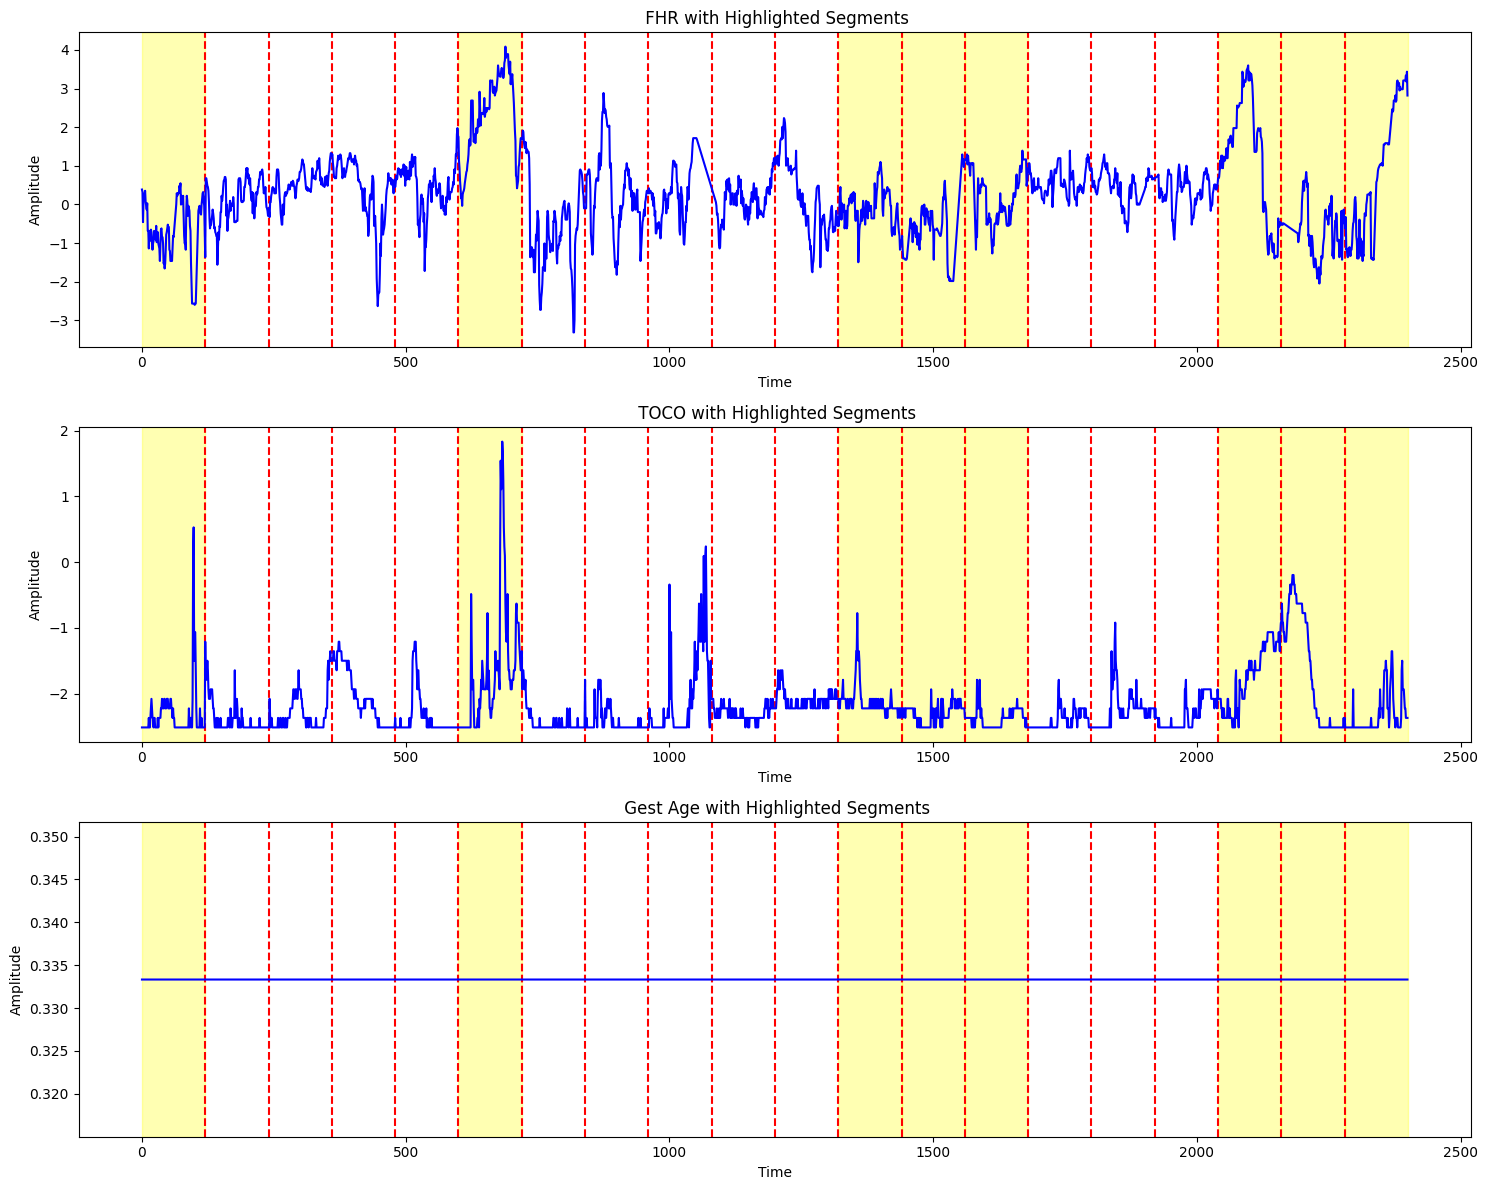

In [ ]:
visualize_lime_explanation_(instance_signal, top_influential_segments, num_slices)

##Conclusion


As seen from the plots above, we could identify the most influential segments of the signal (yellow segments) from our analysis. These highlighted segments showcase the most important parts of the signal that significantly impact the model's decision-making process. This visual representation helps to demystify the model's reasoning, highlighting specific signal segments that are critical in influencing its predictions.

In [ ]:
import math

In [ ]:
segment_importance_coefficients[1]*10000

-279.021330064907

In [ ]:
#from visualization import visualize_lime_explanation_color_


def visualize_lime_explanation_color_(instance_sig, top_influential_segments, num_slices, perturb_function=perturb_mean):
    """
    Visualizes the original signal and highlights the top influential segments
    identified by a LIME explanation.

    Parameters:
    - instance_sig (np.ndarray): The original signal.
    - top_influential_segments (np.ndarray): Indices of the top influential segments.
    - num_slices (int): The number of segments the signal is divided into.
    - perturb_function (function): The perturbation function used (default is perturb_mean).
    """
    plt.figure(figsize=(15, 12))

    channel_labels = ['FHR', 'TOCO', 'Gest Age']

    for i in range(3):
        # Plot the original signal for each channel with highlighted segments
        plt.subplot(3, 1, i + 1)
        for j in range(1, num_slices):
            plt.axvline(x=j * (len(instance_sig) // num_slices), color='r', linestyle='--')
        plt.plot(instance_sig[:, i], label=f'Original {channel_labels[i]}', color='blue')

        for segment in top_influential_segments:
            start_idx = segment * (len(instance_sig) // num_slices)
            end_idx = start_idx + (len(instance_sig) // num_slices)
            importance_coefficient = instance_sig[start_idx:end_idx, i].mean() / instance_sig[:, i].std()
            alpha = min(abs(importance_coefficient * 0.6), 1.0)  # Clip alpha to be within 0-1 range
            if importance_coefficient > 0:
                plt.axvspan(start_idx, end_idx, color='red', alpha=alpha)  # Positive influence which push results to pathological
            else:
                plt.axvspan(start_idx, end_idx, color='green', alpha=alpha)  # Negative influence which push results to healty

        plt.title(f'{channel_labels[i]} with Highlighted Segments')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()



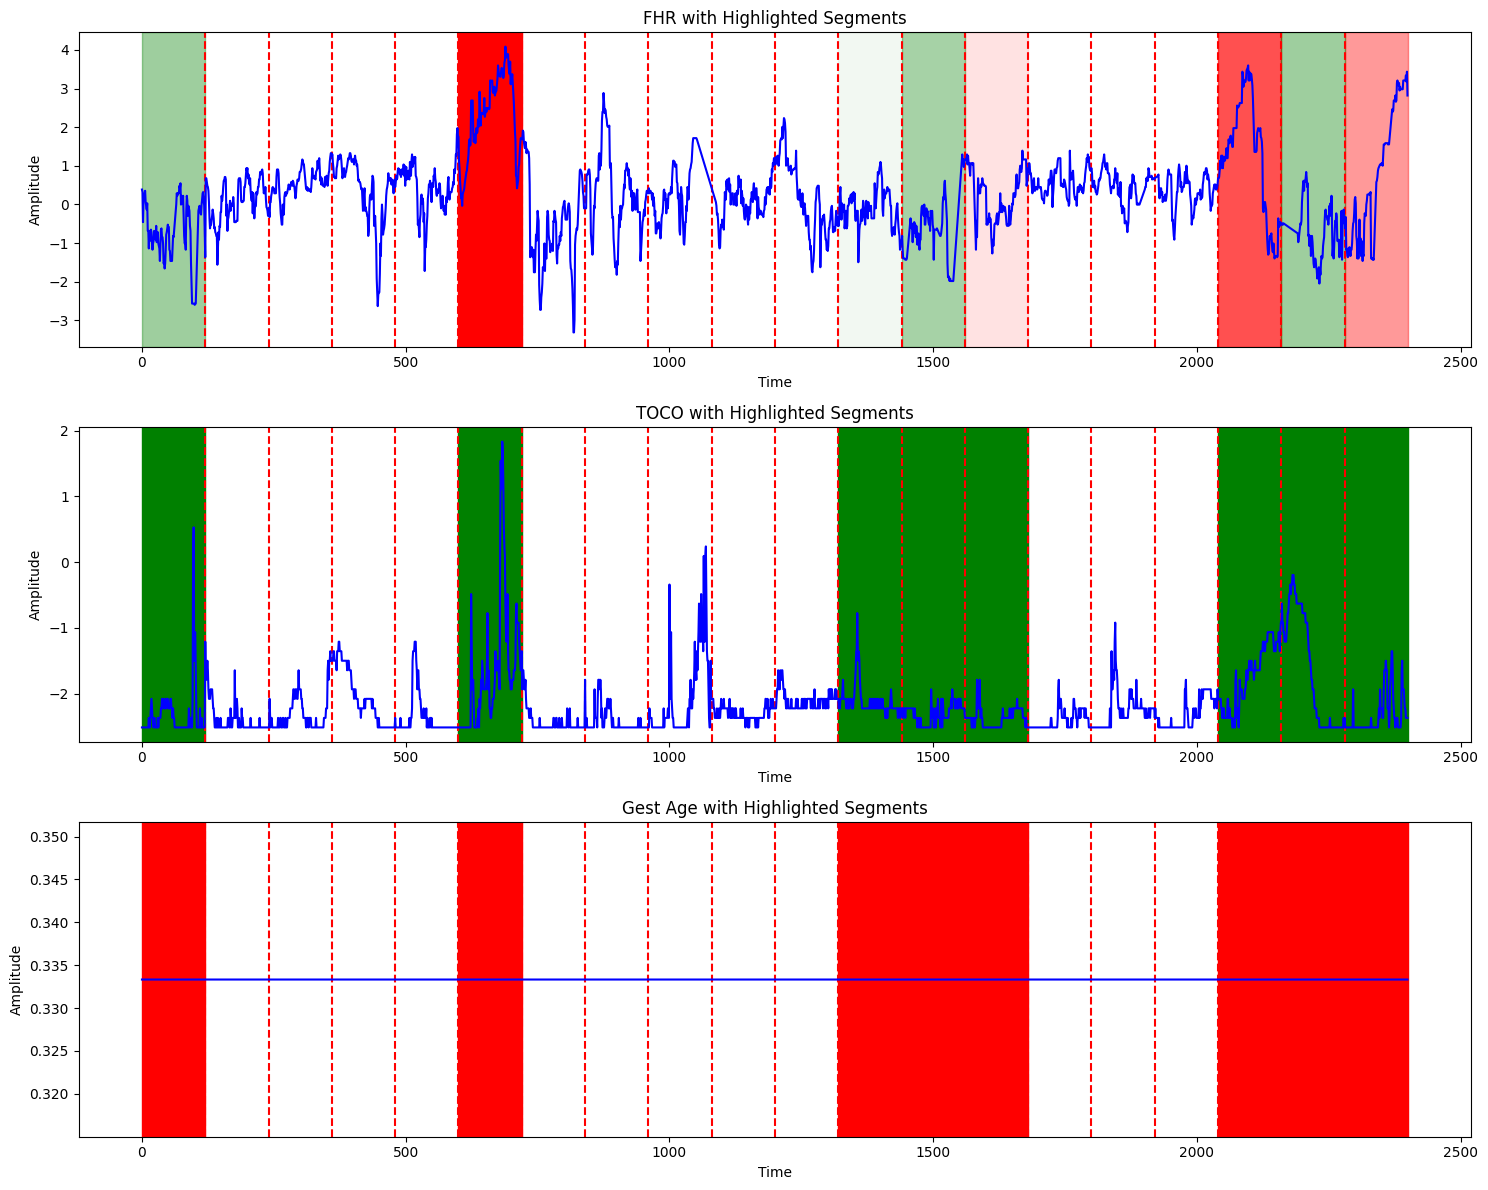

In [ ]:
visualize_lime_explanation_color_(instance_signal, top_influential_segments, num_slices, perturb_function=perturb_mean)

In [ ]:
def calculate_baseline(signal):
    """
    Calculates the baseline of the signal.

    Parameters:
    - signal (np.ndarray): The input signal for which to calculate the baseline.

    Returns:
    - baseline (np.ndarray): The calculated baseline of the signal.
    """
    window_size = 120
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def calculate_global_variance(signal):
    """
    Calculates the global variance of the signal.

    Parameters:
    - signal (np.ndarray): The input signal for which to calculate the variance.

    Returns:
    - variance (float): The variance of the signal.
    """
    return np.var(signal)

def visualize_lime_with_variation(instance_sig, top_influential_segments, num_slices):
    """
    Visualizes the original signal and highlights the top influential segments
    identified by a LIME explanation.

    Parameters:
    - instance_sig (np.ndarray): The original signal.
    - top_influential_segments (np.ndarray): Indices of the top influential segments.
    - num_slices (int): The number of segments the signal is divided into.
    """
    plt.figure(figsize=(15, 12))

    channel_labels = ['FHR', 'TOCO', 'Gest Age']

    for i in range(3):
        # Calculate the baseline and global variance of the signal using the defined functions
        baseline = calculate_baseline(instance_sig[:, i])
        global_variance = calculate_global_variance(instance_sig[:, i])
        std_dev = np.sqrt(global_variance)  # Standard deviation is the square root of variance

        # Plot the original signal for each channel with highlighted segments
        plt.subplot(3, 1, i + 1)
        for j in range(1, num_slices):
            plt.axvline(x=j * (len(instance_sig) // num_slices), color='r', linestyle='--')
        plt.plot(instance_sig[:, i], label=f'Original {channel_labels[i]}', color='blue')
        plt.plot(baseline, color='black', linewidth=3, label=f'Baseline {channel_labels[i]}')  # Add baseline

        # Add shaded region for ±1 standard deviation
        plt.fill_between(np.arange(len(instance_sig[:, i])),
                         baseline - std_dev,
                         baseline + std_dev,
                         color='grey', alpha=0.8, label=f'±1 Std Dev {channel_labels[i]}')

        for segment in top_influential_segments:
            start_idx = segment * (len(instance_sig) // num_slices)
            end_idx = start_idx + (len(instance_sig) // num_slices)
            importance_coefficient = instance_sig[start_idx:end_idx, i].mean() / instance_sig[:, i].std()
            a = min(abs(importance_coefficient * 0.6), 1.0)  # Clip alpha to be within 0-1 range
            if importance_coefficient > 0:
                plt.axvspan(start_idx, end_idx, color='red', alpha=a) # Positive influence which push results to pathological
            else:
                plt.axvspan(start_idx, end_idx, color='green', alpha=a)  # Negative influence which push results to healty

        plt.title(f' {channel_labels[i]} with Highlighted Segments and ±1 Std Dev')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()


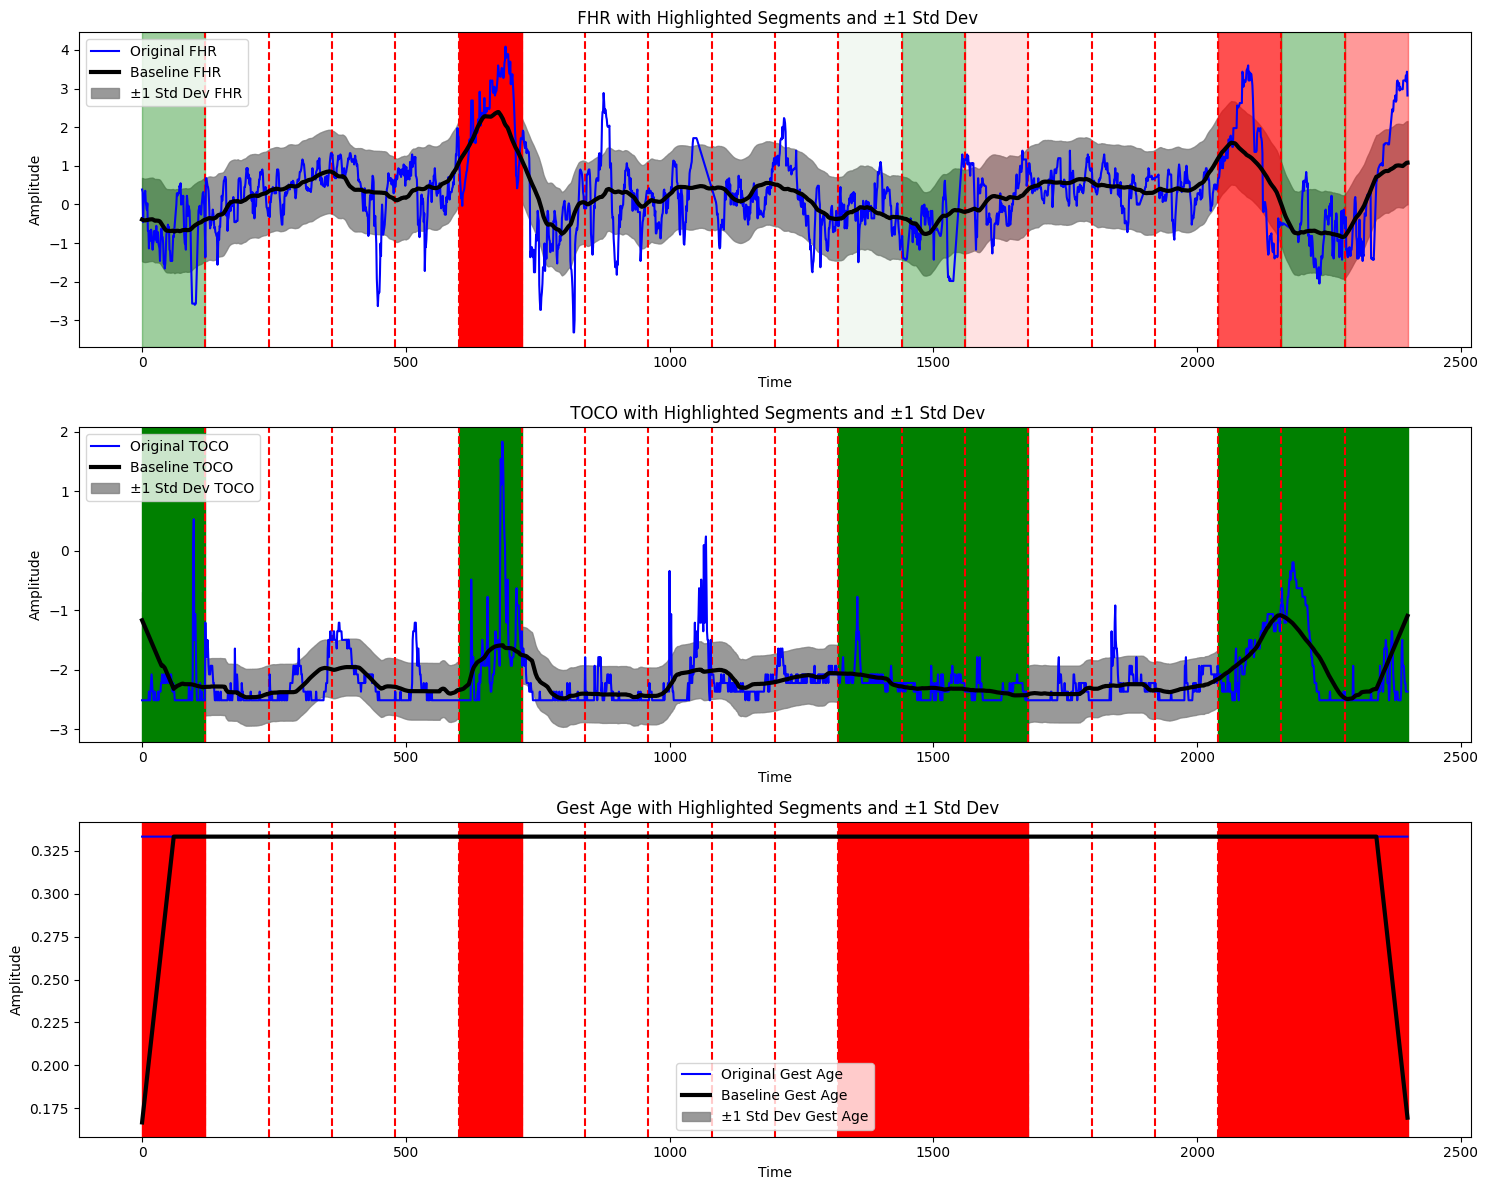

In [ ]:
visualize_lime_with_variation(instance_signal, top_influential_segments, num_slices)

In [ ]:
def calculate_baseline(signal):
    """
    Calculates the baseline of the signal using the total mean.

    Parameters:
    - signal (np.ndarray): The input signal for which to calculate the baseline.

    Returns:
    - baseline (np.ndarray): The calculated baseline of the signal.
    """
    total_mean = np.mean(signal)
    return np.full(signal.shape, total_mean)

def calculate_global_variance(signal):
    """
    Calculates the global variance of the signal.

    Parameters:
    - signal (np.ndarray): The input signal for which to calculate the variance.

    Returns:
    - variance (float): The variance of the signal.
    """
    return np.var(signal)

def visualize_lime_with_variation(instance_sig, top_influential_segments, num_slices):
    """
    Visualizes the original signal and highlights the top influential segments
    identified by a LIME explanation.

    Parameters:
    - instance_sig (np.ndarray): The original signal.
    - top_influential_segments (np.ndarray): Indices of the top influential segments.
    - num_slices (int): The number of segments the signal is divided into.
    """
    plt.figure(figsize=(15, 12))

    channel_labels = ['FHR', 'TOCO', 'Gest Age']

    for i in range(3):
        # Calculate the baseline and global variance of the signal using the defined functions
        baseline = calculate_baseline(instance_sig[:, i])
        global_variance = calculate_global_variance(instance_sig[:, i])
        std_dev = np.sqrt(global_variance)  # Standard deviation is the square root of variance

        # Plot the original signal for each channel with highlighted segments
        plt.subplot(3, 1, i + 1)
        for j in range(1, num_slices):
            plt.axvline(x=j * (len(instance_sig) // num_slices), color='r', linestyle='--')
        plt.plot(instance_sig[:, i], label=f'Original {channel_labels[i]}', color='blue')
        plt.plot(baseline, color='black', linewidth=3, label=f'Baseline {channel_labels[i]}')  # Add baseline

        # Add shaded region for ±1 standard deviation
        plt.fill_between(np.arange(len(instance_sig[:, i])),
                         baseline - std_dev,
                         baseline + std_dev,
                         color='grey', alpha=0.8, label=f'±1 Std Dev {channel_labels[i]}')

        for segment in top_influential_segments:
            start_idx = segment * (len(instance_sig) // num_slices)
            end_idx = start_idx + (len(instance_sig) // num_slices)
            importance_coefficient = instance_sig[start_idx:end_idx, i].mean() / instance_sig[:, i].std()
            a = min(abs(importance_coefficient * 0.6), 1.0)  # Clip alpha to be within 0-1 range
            if importance_coefficient > 0:
                plt.axvspan(start_idx, end_idx, color='red', alpha=a) # Positive influence which push results to pathological
            else:
                plt.axvspan(start_idx, end_idx, color='green', alpha=a)  # Negative influence which push results to healthy

        plt.title(f' {channel_labels[i]} with Highlighted Segments and ±1 Std Dev')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()


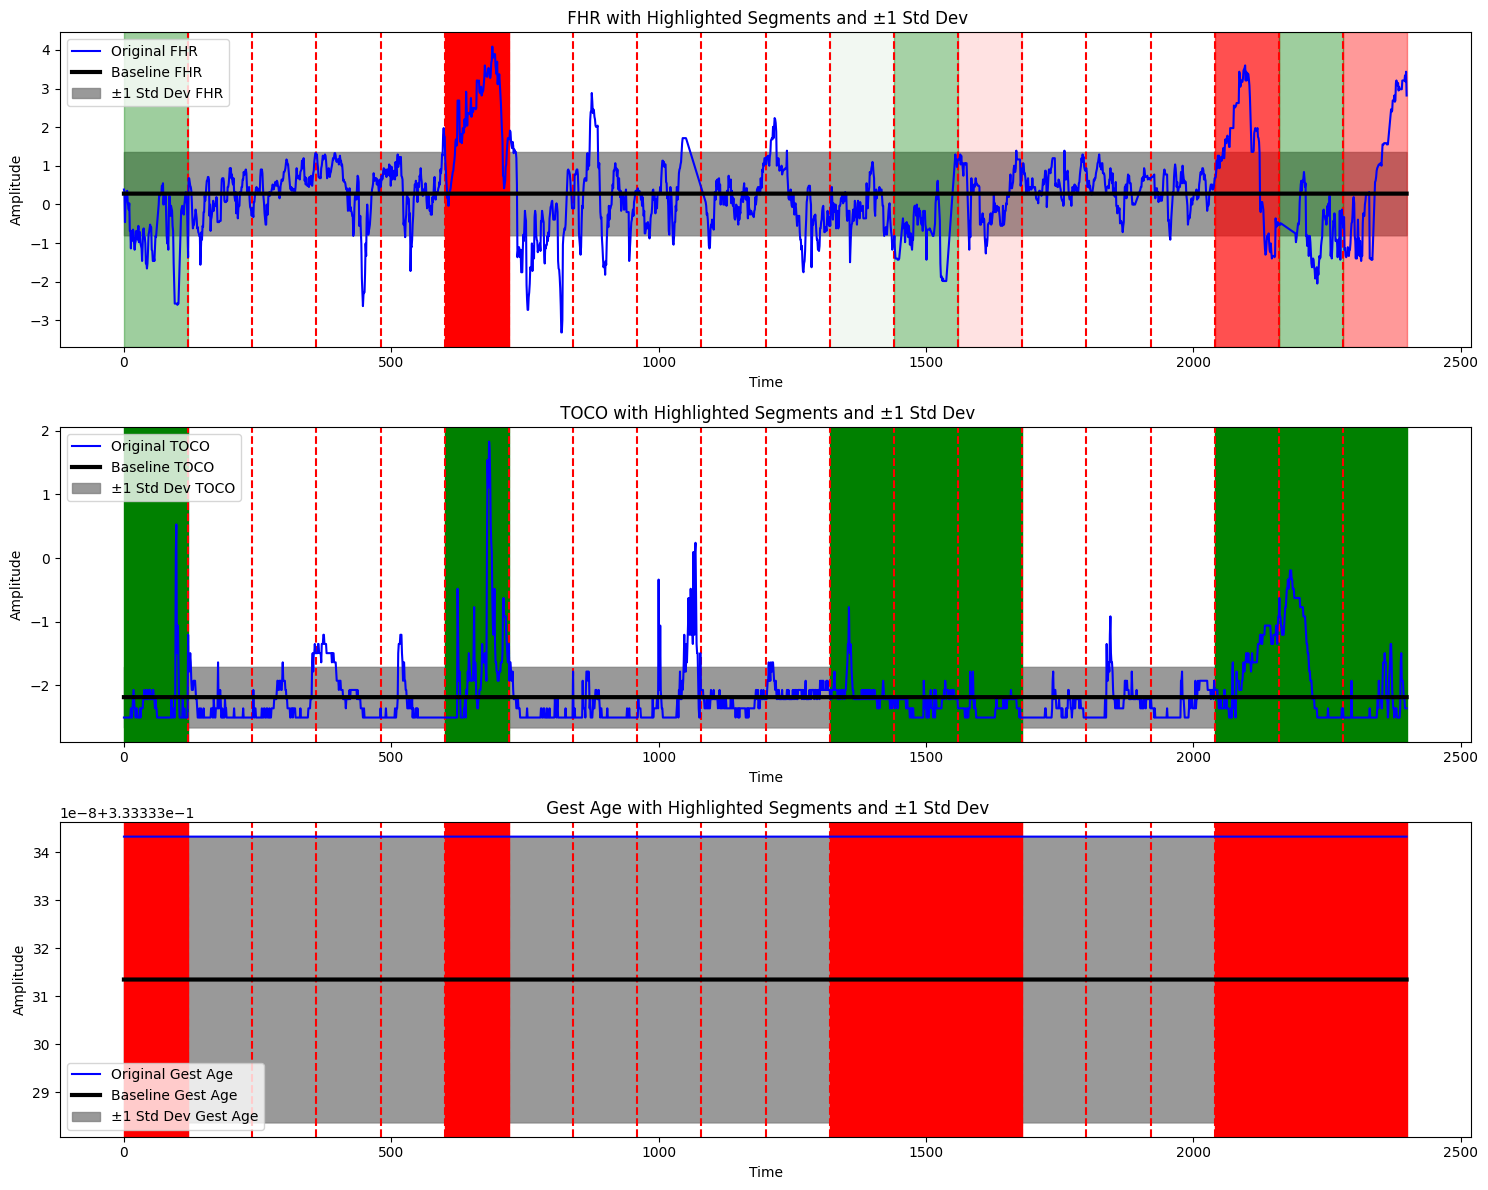

In [ ]:
visualize_lime_with_variation(instance_signal, top_influential_segments, num_slices)

In [283]:
def visualize_lime_with_mantel(instance_sig, top_influential_segments, num_slices):
    """
    Visualizes the original signal and highlights the top influential segments
    identified by a LIME explanation.

    Parameters:
    - instance_sig (np.ndarray): The original signal.
    - top_influential_segments (np.ndarray): Indices of the top influential segments.
    - num_slices (int): The number of segments the signal is divided into.
    """


  #Plot the original signal and the downsampled baseline
    plt.figure(figsize=(12, 6))

    fig, ax = plot_segmented_signal_(ins, segment_signal(ins, num_slices), 'FHR')

  # Plot downsampled baseline
    ax.plot(baseline_2Hz,  label='Baseline (2Hz)', color='red')

  # İndekslerin tam sayı olduğundan emin olalım
    acc = np.array(accelerations_2Hz[2], dtype=int)
    dec = np.array(decelerations_2Hz[2], dtype=int)

  # Scatter plot ile noktaları ekleyelim
    ax.scatter(acc, ins[acc], color='red', label='Acceleration Points', marker='^', s=100)
    ax.scatter(dec, ins[dec], color='black', label='Deceleration Points', marker='v', s=100)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Original Signal and Baseline (Downsampled to 2Hz)')
    # Efsaneyi grafiğin dışında veya içinde bir konumda yerleştirin
    ax.legend(loc='best', bbox_to_anchor=(1.05, 1))  # Efsaneyi grafiğin dışına taşır, 'best' ise otomatik en iyi yerleştirme sağlar

    plt.grid(True)


    for segment in top_influential_segments:
      start_idx = segment * (len(instance_sig) // num_slices)
      end_idx = start_idx + (len(instance_sig) // num_slices)
      importance_coefficient = instance_sig[start_idx:end_idx, i].mean() / instance_sig[:, i].std()
      a = min(abs(importance_coefficient * 0.6), 1.0)  # Clip alpha to be within 0-1 range
      if importance_coefficient > 0:
        plt.axvspan(start_idx, end_idx, color='red', alpha=a) # Positive influence which push results to pathological
      else:
        plt.axvspan(start_idx, end_idx, color='green', alpha=a)  # Negative influence which push results to healthy
    plt.tight_layout()
    plt.show()

<Figure size 1200x600 with 0 Axes>

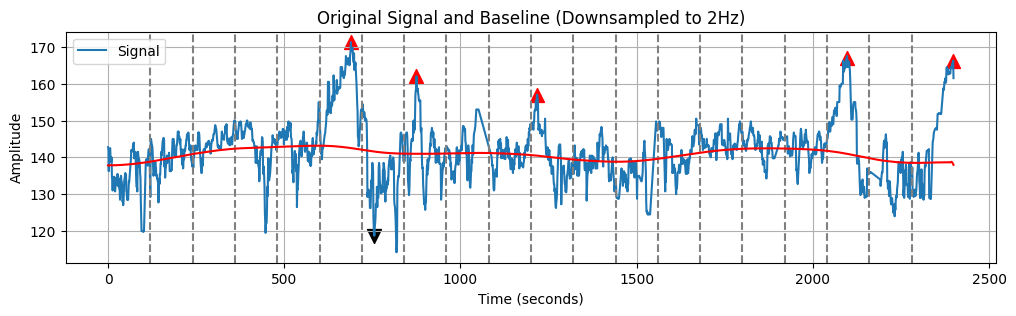

"\nfor i in range(len(accelerations_2Hz[2])):\n  plt.axvline(x=accelerations_2Hz[2][i], color='red', linestyle='--', linewidth=2)\nfor i in range(len(decelerations_2Hz[2])):\n  plt.axvline(x=decelerations_2Hz[2][i], color='black', linestyle='--', linewidth=2)\n\n"

In [281]:
from lime_explanation import segment_signal
from visualization import plot_segmented_signal


#Plot the original signal and the downsampled baseline
plt.figure(figsize=(12, 6))

fig, ax = plot_segmented_signal_(ins, segment_signal(ins, num_slices), 'FHR')

# Plot downsampled baseline
ax.plot(baseline_2Hz,  label='Baseline (2Hz)', color='red')

# İndekslerin tam sayı olduğundan emin olalım
acc = np.array(accelerations_2Hz[2], dtype=int)
dec = np.array(decelerations_2Hz[2], dtype=int)

# Scatter plot ile noktaları ekleyelim
ax.scatter(acc, ins[acc], color='red', label='Acceleration Points', marker='^', s=100)
ax.scatter(dec, ins[dec], color='black', label='Deceleration Points', marker='v', s=100)

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Original Signal and Baseline (Downsampled to 2Hz)')
plt.legend()
plt.grid(True)

plt.show()


'''
for i in range(len(accelerations_2Hz[2])):
  plt.axvline(x=accelerations_2Hz[2][i], color='red', linestyle='--', linewidth=2)
for i in range(len(decelerations_2Hz[2])):
  plt.axvline(x=decelerations_2Hz[2][i], color='black', linestyle='--', linewidth=2)

'''

<Figure size 1200x600 with 0 Axes>

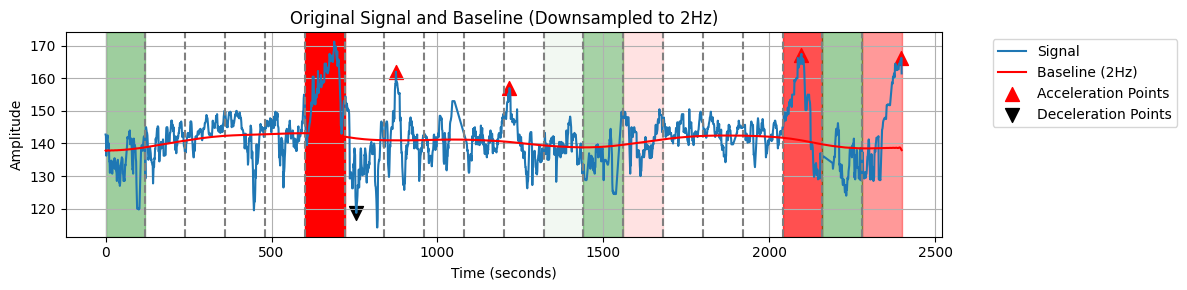

In [284]:
visualize_lime_with_mantel(instance_signal, top_influential_segments, num_slices)

In [287]:
accelerations_2Hz, decelerations_2Hz

(array([[ 611. ,  858.5, 1182.5, 2029.5, 2338. ],
        [ 735.5,  890.5, 1243.5, 2125. , 2399.5],
        [ 689. ,  875.5, 1217. , 2096.5, 2398.5]]),
 array([[735. ],
        [800.5],
        [755.5]]))

In [290]:
print("Acceleration Amounts:", accelerations_2Hz[1]-accelerations_2Hz[0])

Acceleration Amounts: [124.5  32.   61.   95.5  61.5]


In [291]:
print("Deceleration Amounts:", decelerations_2Hz[1]-decelerations_2Hz[0])

Deceleration Amounts: [65.5]


#SHAP1


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
import shap
from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP
%matplotlib inline
shap.initjs()

In [ ]:
import timeit
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

In [ ]:
num_background = 20
num_test = 18
background_data, test_data = combined_data_train[:num_background], combined_data_test[num_test:num_test+2]

In [ ]:
background_data.shape, test_data.shape

((20, 2400, 3), (2, 2400, 3))

In [ ]:
train_data_tensor.shape, test_data_tensor.shape

(TensorShape([827, 2400, 3]), TensorShape([128, 2400, 3]))

In [ ]:
import numpy as np
import tensorflow as tf
import shap

class StationaryWindowSHAP:
    def __init__(self, model, window_len, B_ts, test_ts, B_mask=None, B_dem=None,
                 test_mask=None, test_dem=None, model_type='cnn'):
        self.model = model
        self.window_len = window_len
        self.num_window = np.ceil(B_ts.shape[1]/self.window_len).astype('int') #how many window
        self.num_background = len(B_ts)
        self.num_test = len(test_ts)
        self.background_ts = B_ts
        self.background_mask = B_mask
        self.background_dem = B_dem
        self.test_ts = test_ts
        self.test_mask = test_mask
        self.test_dem = test_dem
        self.model_type = model_type
        self.ts_phi = None
        self.dem_phi = None
        self.explainer = None

        # Problem sizes
        self.num_ts_ftr = B_ts.shape[2]
        self.num_ts_step = B_ts.shape[1]
        self.num_dem_ftr = 0 if B_dem is None else B_dem.shape[1]

        # Creating all data (background and test together)
        self.all_ts = np.concatenate((self.background_ts, self.test_ts), axis=0)
        self.all_mask = None if test_mask is None else np.concatenate((self.background_mask, self.test_mask), axis=0)
        self.all_dem = None if test_dem is None else np.concatenate((self.background_dem, self.test_dem), axis=0)

        # Creating converted data for SHAP
        self.background_data = self.data_prepare(ts_x=self.background_ts, dem_x=self.background_dem, start_idx=0)
        self.test_data = self.data_prepare(ts_x=self.test_ts, dem_x=self.test_dem, start_idx=self.num_background)

    def data_prepare(self, ts_x, dem_x=None, start_idx=0):
        #assert len(ts_x.shape) == 3
        #assert dem_x is None or len(dem_x.shape) == 2
        dem_len = 0 if dem_x is None else dem_x.shape[1]

        total_num_features = self.num_dem_ftr + self.num_ts_ftr * self.num_window

        x_ = [[i]*total_num_features for i in range(start_idx, start_idx + ts_x.shape[0])]

        return np.array(x_)

    def wraper_predict(self, x):
        assert len(x.shape) == 2

        dem_x, ts_x = x[:, :self.num_dem_ftr].copy(), x[:, self.num_dem_ftr:].copy()

        # initializing the value of all arrays
        ts_x_ = np.zeros((x.shape[0], self.all_ts.shape[1], self.all_ts.shape[2]))
        mask_x_ = np.zeros_like(ts_x_)
        dem_x_ = np.zeros_like(dem_x, dtype=float)
        tstep = np.ones((x.shape[0], self.all_ts.shape[1], 1)) * \
                    np.reshape(np.arange(0, self.all_ts.shape[1]), (1, self.all_ts.shape[1], 1))

        # Reshaping the ts indices based on the num time windows and features
        ts_x = ts_x.reshape((ts_x.shape[0], self.num_window, self.num_ts_ftr))

        for i in range(x.shape[0]):
            # creating time series data
            for t in range(self.num_ts_step):
                for j in range(self.num_ts_ftr):
                    # Finding the corresponding time interval
                    wind_t = np.ceil((t+1)/self.window_len).astype('int') - 1
                    ind = ts_x[i, wind_t, j]
                    ts_x_[i, t, j] = self.all_ts[ind, t, j]
                    mask_x_[i, t, j] = None if self.all_mask is None else self.all_mask[ind, t, j]
            # creating static data
            for j in range(dem_x.shape[1]):
                ind = dem_x[i,j]
                dem_x_[i, j] = None if self.all_dem is None else self.all_dem[ind, j]

        # Creating the input of the model based on the different models.
        # This part should be updated as new models get involved in the project
        if self.model_type == 'cnn':  # Adapting for CNN model
            model_input = tf.convert_to_tensor(ts_x_, dtype=tf.float32)

        return self.model(model_input)

    def shap_values(self, num_output=1):
        self.explainer = shap.KernelExplainer(self.wraper_predict, self.background_data)
        shap_values = self.explainer.shap_values(self.test_data)
        shap_values = np.array(shap_values)

        self.dem_phi = shap_values[:, :, :self.num_dem_ftr]
        ts_shap_values = shap_values[:, :, self.num_dem_ftr:]
        self.ts_phi = ts_shap_values.reshape((num_output, self.num_test, self.num_window, self.num_ts_ftr))

        # assign values to each single time step by deviding the values by window length
        self.ts_phi = np.repeat(self.ts_phi/self.window_len, self.window_len, axis=2)[:,:,:self.num_ts_step,:]

        # Reporting only the first output
        self.ts_phi = self.ts_phi[0]
        self.dem_phi = self.dem_phi[0]

        return self.ts_phi if self.num_dem_ftr==0 else (self.dem_phi, self.ts_phi)


In [ ]:
test_data.shape, len(test_data)

((2, 2400, 3), 2)

In [ ]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 800
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='cnn')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

  0%|          | 0/1 [00:00<?, ?it/s]

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall/StatefulPartitionedCall/conv1d_25/StatefulPartitionedCall/Conv1D-0-0-TransposeNCHWToNHWC-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[10200,1,2400,48] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/conv1d_25/StatefulPartitionedCall/Conv1D-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_restored_function_body_11369]

In [ ]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 1200
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='cnn')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time: 60.28473800000029


In [ ]:
np.absolute(ts_phi_1)

array([[[1.22082575e-04, 1.07339346e-04, 1.56702529e-04],
        [1.22082575e-04, 1.07339346e-04, 1.56702529e-04],
        [1.22082575e-04, 1.07339346e-04, 1.56702529e-04],
        ...,
        [7.45087503e-05, 3.81527769e-05, 1.89697494e-05],
        [7.45087503e-05, 3.81527769e-05, 1.89697494e-05],
        [7.45087503e-05, 3.81527769e-05, 1.89697494e-05]],

       [[5.28372584e-05, 6.09504561e-05, 2.60307586e-05],
        [5.28372584e-05, 6.09504561e-05, 2.60307586e-05],
        [5.28372584e-05, 6.09504561e-05, 2.60307586e-05],
        ...,
        [2.10982934e-04, 1.39497759e-04, 8.59489664e-06],
        [2.10982934e-04, 1.39497759e-04, 8.59489664e-06],
        [2.10982934e-04, 1.39497759e-04, 8.59489664e-06]]])

In [ ]:
combined_data_test[num_test + 0, :, 0].shape, ts_phi_1[0, :, 0].shape

((2400,), (2400,))

In [ ]:
import numpy as np
import math
from copy import deepcopy

def xai_eval_fnc(model, relevence, input_x, model_type='lstm', percentile=90,
                 eval_type='prtb', seq_len=10, by='all'):
    """
    Evaluates the quality metrics of time-series importance scores using various evaluation methods.

    Parameters
    ----------
    model : prediction model that is explained
    relevance : A 3D array of importance scores for each time step of the time-series data
    input_x : input data of the prediction model. If the input data consists of different modalities, the first module should be a 3D time series data
    model_type (optional) : type of model, either 'lstm' or 'lstm_plus'. Use 'lstm' when the time series data is the only modality of the input, otherwise use 'lstm_plus'
    percentile (optional) : percentile of top time steps that are going to be pertubed
    eval_type (optional) : evaluation method, either 'prtb' for the perturbation analysis metric or 'sqnc' for sequence analysis metric
    seq_len (optional) : sequence length for 'sqnc' method
    by (optional) : whether to evaluate each temporal feature separately or all time steps together, either 'time' or 'all'

    Returns : prediction of the modified input time-series data using the input model
    """

    input_new = deepcopy(input_x)
    relevence = np.absolute(relevence)

    # TO DO: Add other type of models
    if model_type == 'lstm_plus':
        input_ts = input_x[0]
        input_new_ts = input_new[0]
    elif model_type == 'lstm':
        input_ts = input_x
        input_new_ts = input_new

    assert len(input_ts.shape)==3 # the time sereis data needs to be 3-dimensional
    num_feature = input_ts.shape[2]
    num_time_step = input_ts.shape[1]
    num_instance = input_ts.shape[0]

    if by=='time':
        top_steps = math.ceil((1 - percentile/100) * num_time_step) # finding the number of top steps for each feature
        top_indices = np.argsort(relevence, axis=1)[:, -top_steps:, :] # a 3d array of top time steps for each feature
        for j in range(num_feature): # converting the indices to a flatten version
            top_indices[:, :, j] = top_indices[:, :, j] * num_feature + j
        top_indices = top_indices.flatten()
    elif by=='all':
        top_steps = math.ceil((1 - percentile/100) * num_time_step * num_feature) # finding the number of all top steps
        top_indices = np.argsort(relevence, axis=None)[-top_steps:]

    # Create a masking matrix for top time steps
    top_indices_mask = np.zeros(input_ts.size)
    top_indices_mask[top_indices] = 1
    top_indices_mask = top_indices_mask.reshape(input_ts.shape)


    # Evaluating different metrics
    for p in range(num_instance):
        for v in range(num_feature):
            for t in range(num_time_step):
                if top_indices_mask[p, t, v]:
                    if eval_type == 'prtb':
                        input_new_ts[p,t,v] = np.max(input_ts[p,:,v]) - input_ts[p,t,v]
                    elif eval_type == 'sqnc':
                        input_new_ts[p, t:t + seq_len, v] = 0

    return model.predict(input_new)


def heat_map__(start, stop, x, shap_values, var_name='Feature 1', plot_type='bar', title=None):
    """
    A function that generates a heatmap with the temporal sequence alongside its Shapley values

    Parameters
    ----------
    start (int): the starting point of the temporal sequence
    stop (int): the ending point of the temporal sequence
    x (np.ndarray): the sequence data
    shap_values (np.ndarray): the Shapley values corresponding to the sequence data
    var_name (str): the name of the variable being plotted (default: 'Feature 1')
    plot_type (str): the type of plot to generate ('bar' or 'heat' or 'heat_abs', default: 'bar')
    title (str): the title for the plot (default: None)
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from textwrap import wrap

    ## ColorMap-------------------------
    # define the colormap
    cmap = plt.get_cmap('PuOr_r')

    # extract all colors from the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new colormap
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bounds and normalize
    shap_min, shap_max = np.min(shap_values), np.max(shap_values)
    if shap_min == shap_max:
        bounds = np.linspace(shap_min - 0.1, shap_max + 0.1, 3)  # Ensure at least 2 boundaries
    else:
        bounds = np.linspace(shap_min, shap_max, 256)  # Adjust number of points as needed
    idx = np.searchsorted(bounds, 0)
    bounds = np.insert(bounds, idx, 0)
    norm = BoundaryNorm(bounds, cmap.N)
    ##------------------------------------

    if title is None:
        title = '\n'.join(wrap('{} values and contribution scores'.format(var_name), width=40))

    if plot_type == 'heat' or plot_type == 'heat_abs':
        plt.rcParams["figure.figsize"] = 9, 3
        if plot_type == 'heat_abs':
            shap_values = np.absolute(shap_values)
            cmap = plt.get_cmap('Reds')
        fig, ax1 = plt.subplots(sharex=True)
        extent = [start, stop, -2, 2]
        im1 = ax1.imshow(shap_values[np.newaxis, :], cmap=cmap, norm=norm, aspect="auto", extent=extent)
        ax1.set_yticks([])
        ax1.set_xlim(extent[0], extent[1])
        ax1.title.set_text(title)
        fig.colorbar(im1, ax=ax1, pad=0.1)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, color='black')
    elif plot_type == 'bar':
        plt.rcParams["figure.figsize"] = 8.5, 2.5
        fig, ax1 = plt.subplots(sharex=True)
        mask1 = shap_values < 0
        mask2 = shap_values >= 0
        ax1.bar(np.arange(start, stop)[mask1], shap_values[mask1], color='blue', label='Negative Shapley values')
        ax1.bar(np.arange(start, stop)[mask2], shap_values[mask2], color='red', label='Positive Shapley values')
        ax1.set_title(title)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, 'k-', label='Observed data')
        # legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc=0)

    ax1.set_xlabel('Time steps')
    if plot_type == 'bar': ax1.set_ylabel('Shapley values')
    ax2.set_ylabel(var_name + ' data values')
    plt.tight_layout()
    plt.show()


In [ ]:
ts_phi_1

array([[[ 1.22082575e-04, -1.07339346e-04,  1.56702529e-04],
        [ 1.22082575e-04, -1.07339346e-04,  1.56702529e-04],
        [ 1.22082575e-04, -1.07339346e-04,  1.56702529e-04],
        ...,
        [ 7.45087503e-05, -3.81527769e-05,  1.89697494e-05],
        [ 7.45087503e-05, -3.81527769e-05,  1.89697494e-05],
        [ 7.45087503e-05, -3.81527769e-05,  1.89697494e-05]],

       [[ 5.28372584e-05, -6.09504561e-05,  2.60307586e-05],
        [ 5.28372584e-05, -6.09504561e-05,  2.60307586e-05],
        [ 5.28372584e-05, -6.09504561e-05,  2.60307586e-05],
        ...,
        [ 2.10982934e-04, -1.39497759e-04,  8.59489664e-06],
        [ 2.10982934e-04, -1.39497759e-04,  8.59489664e-06],
        [ 2.10982934e-04, -1.39497759e-04,  8.59489664e-06]]])

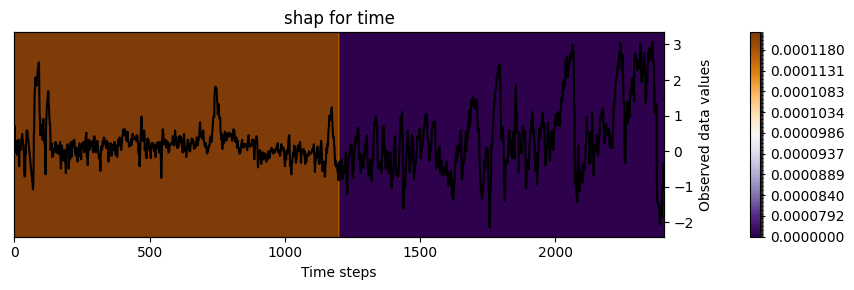

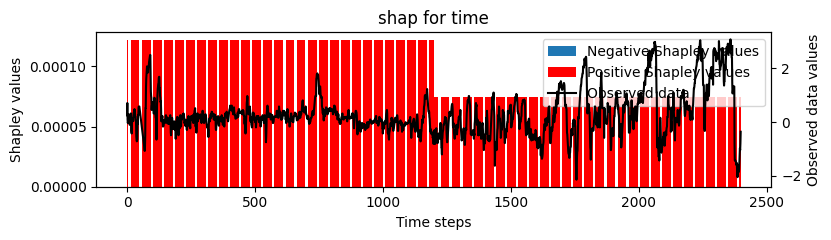

In [ ]:
#from util import heat_map
var = 0
phi_index = 0
heat_map__(start=0, stop=2400, x=combined_data_test[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='heat', title='shap for time')
heat_map__(start=0, stop=2400, x=combined_data_test[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar', title='shap for time')
#heat_map_(start=0, stop=2400, x=combined_data_test[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index+1, :, var+1], var_name='Observed', plot_type='bar')
#heat_map_(start=0, stop=2400, x=combined_data_test[num_test + phi_index, :, var], shap_values=ts_phi_3[phi_index, :, var], var_name='Variable', plot_type='bar')

##Error because of loading of saved_model (it is not supported by DeepExplainer)

In [ ]:
# Assuming train_data_tensor is your TensorFlow tensor with shape [num_examples, ...]
num_examples = train_data_tensor.shape[0]

# Generate random indices without replacement
indices = tf.random.shuffle(tf.range(num_examples))[:100]

# select a set of background examples to take an expectation over
background = tf.gather(train_data_tensor, indices)


In [ ]:
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


ValueError: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'> is not currently a supported model type!